In [2]:
import numpy as np
import scipy.stats
import scipy.special
import scipy.optimize
import scipy.integrate
import matplotlib.pyplot as plt

In [107]:
title = "# Introduction to Bayesian statistics"
# Print title and setup TeX defs for both KaTeX and MathJax
import bayesian_stats_course_tools
bayesian_stats_course_tools.misc.display_markdown_and_setup_tex(title)

import matplotlib.style
matplotlib.style.use("bayesian_stats_course_tools.light")

# Introduction to Bayesian statistics

<!-- Define LaTeX macros -->
$\def\E{\operatorname{E}}$
$\def\Var{\operatorname{Var}}$
$\def\Cov{\operatorname{Cov}}$
$\def\dd{\mathrm{d}}$
$\def\ee{\mathrm{e}}$
$\def\Norm{\mathcal{N}}$
$\def\Uniform{\mathcal{U}}$

<!-- MathJax needs them to be defined again for the non-inline environment -->
$$\def\E{\operatorname{E}}$$
$$\def\Var{\operatorname{Var}}$$
$$\def\Cov{\operatorname{Cov}}$$
$$\def\dd{\mathrm{d}}$$
$$\def\ee{\mathrm{e}}$$
$$\def\Norm{\mathcal{N}}$$
$$\def\Uniform{\mathcal{U}}$$

In Bayesian statistics we want to infer the probability distribution of some unobserved parameters $\theta$, given some data $d$. 

That is, we want to infer the *posterior* probability distribution $p(\theta | d)$. It is called posterior, because it describes the probability of $\theta$ *after* we have observed the data.

Using Bayes' theorem, we can write the posterior as
$$
    p(\theta | d) = \frac{p(d | \theta)p(\theta)}{p(d)}
$$



The different terms on the right-hand side have specific names:
- The *likelihood* $p(d | \theta)$ is the probability of the data $d$, given the parameters $\theta$
- The *prior* $p(\theta)$ is the probability of the parameters $\theta$ (in the sense of our degree of believe) *before* we observe the data $d$. 
- The *evidence* $p(d)$ (sometimes also called marginal likelihood) can often be treated as an overall normalisation factor and ignored. It becomes important for model comparison, however.

The power of Bayes' theorem comes from how it relates what we want to know (the probability of the parameters, given the data) to what we can calculate (the probability of the data, given the parameters).

Consider the case of an urn with $n$ balls, $r$ of which are red and $w$ of which are white. The question is then often along the lines of "what is the probability of getting 2 red balls in 5 draws?"

In science, we are usually faced with a different problem: we have just drawn 2 red balls and 3 white ones and we want to know how many balls of each kind are in the urn.

Here Bayes comes to the rescue:
$$
    p(\text{content of urn}|\text{data}) \propto p(\text{data}|\text{content of urn})p(\text{content of urn})
$$

### Likelihood

The first term is the likelihood $p(\text{data}|\text{content of urn})$, which we can (often) calculate.

Assuming that we are drawing with replacement, no clumping of the balls or other funny business, the probability of drawing a red ball is $\theta=\frac{r}{n}$.

We assume we know the total number of balls in the urn $n$.

The probability of drawing $k$ red balls in $t$ trials it is given by a binomial distribution:
$$
    p(k, t| r) = \binom{t}{k}\left(\frac{r}{n}\right)^k\left(1-\frac{r}{n}\right)^{t-k}
$$
Here the data are $k$ and $t$, the number of red balls we have drawn $k$ and the number of trials $t$. 

The parameter is $r$, the number of red balls in the urn. 



### Prior

The second term is the prior $p(\text{content of urn})$, which we need to define. 

Assuming we have no prior information or other indication on how many of the balls are red, a reasonable assumption is that the number of red balls is equally likely between 0 and $n$:

$$
    p(r) = \frac{1}{n+1}
$$

### Posterior

What is the probability distribution of $r$, the number of red balls, given 2 red balls were drawn in 5 trials? I.e.
$$
    p(r | k=2, t=5)
$$

What is it when 20 red balls were drawn in 50 trials?

In [92]:
n = 10

def likelihood(k, t, r):
    theta = r/n
    return scipy.special.binom(t, k) * theta**k * (1-theta)**(t-k)

def prior(r):
    p = 1/(n+1)
    return p * np.ones_like(r)  # Make prior(r) play nice if r is an array

def posterior(r, k, t):
    return likelihood(k, t, r) * prior(r)

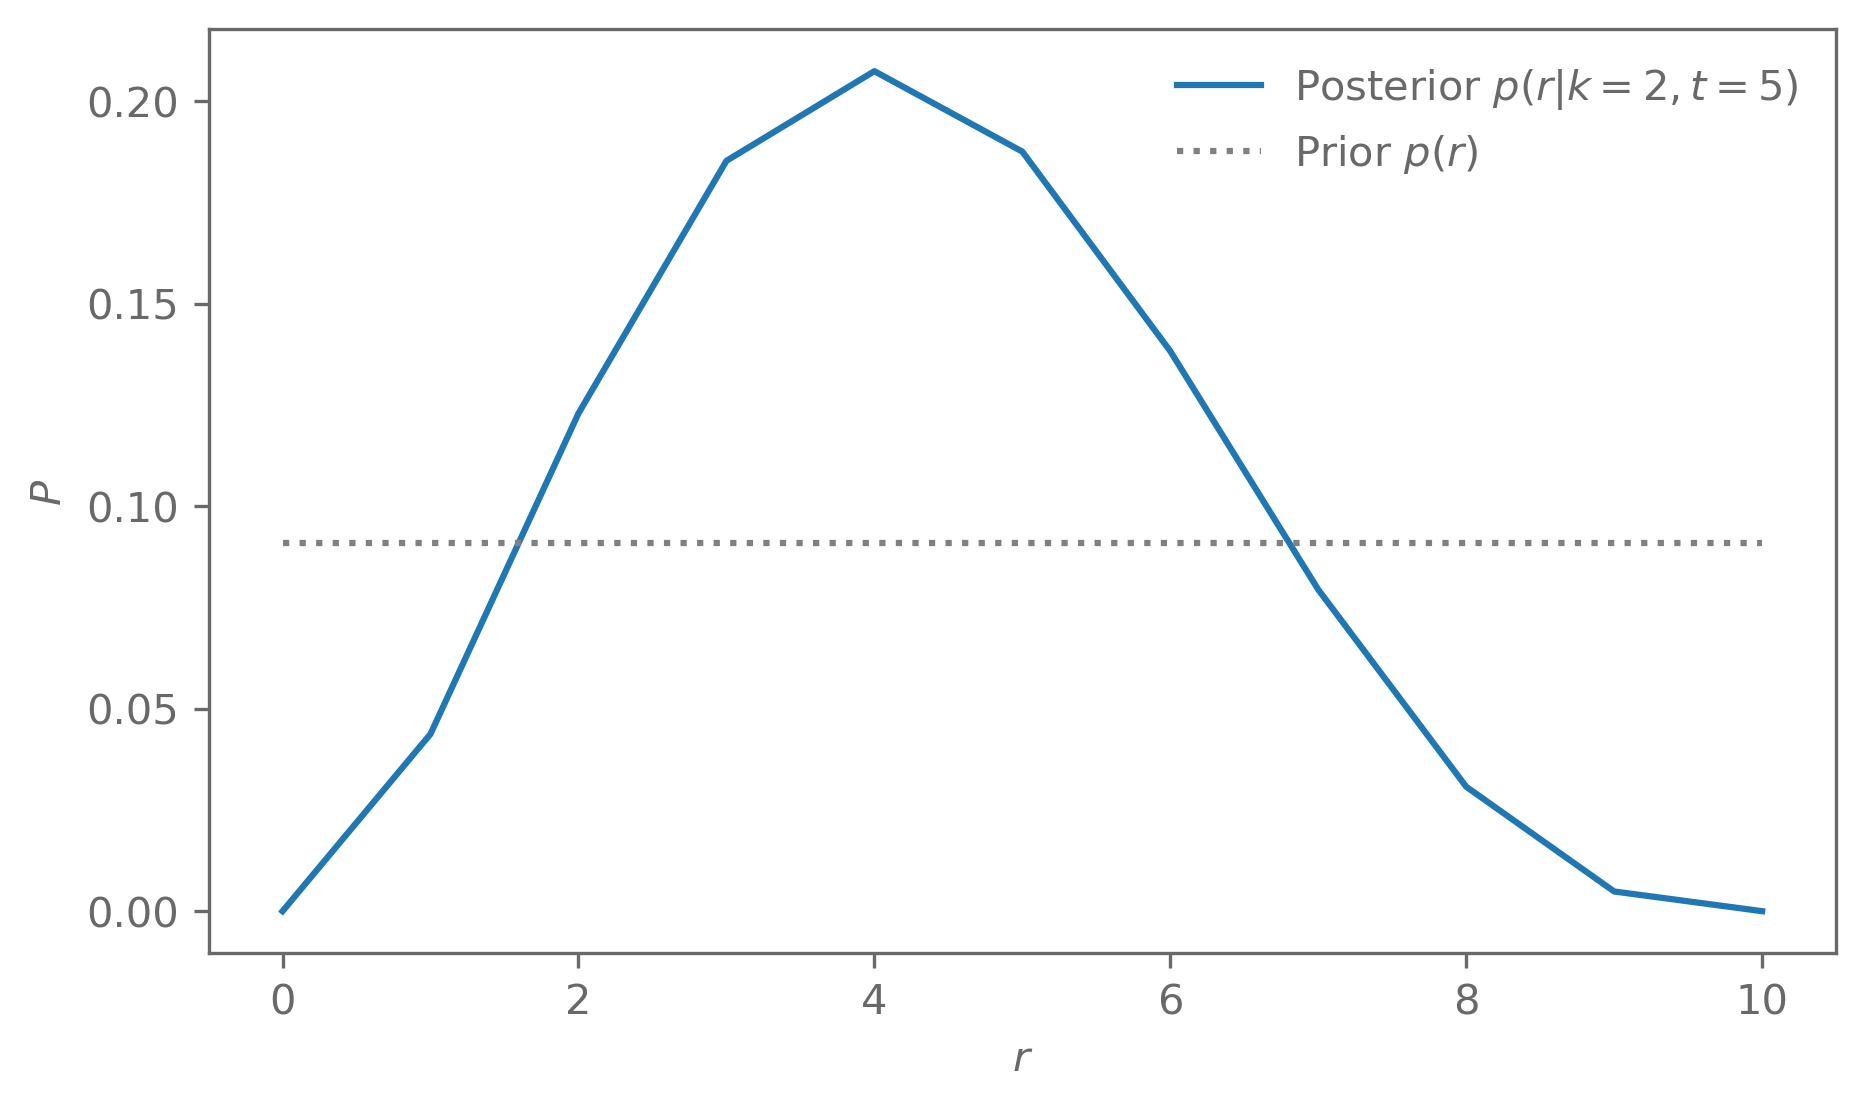

In [93]:
r = np.arange(0, n+1)

posterior_2_5 = posterior(r, k=2, t=5)
# Normalise the posterior
posterior_2_5 /= posterior_2_5.sum()

plt.plot(r, posterior_2_5, label="Posterior $p(r|k=2, t=5)$")
plt.plot(r, prior(r), c="grey", ls=":", label="Prior $p(r)$")
plt.legend(frameon=False)
plt.ylabel("$P$")
plt.xlabel("$r$");

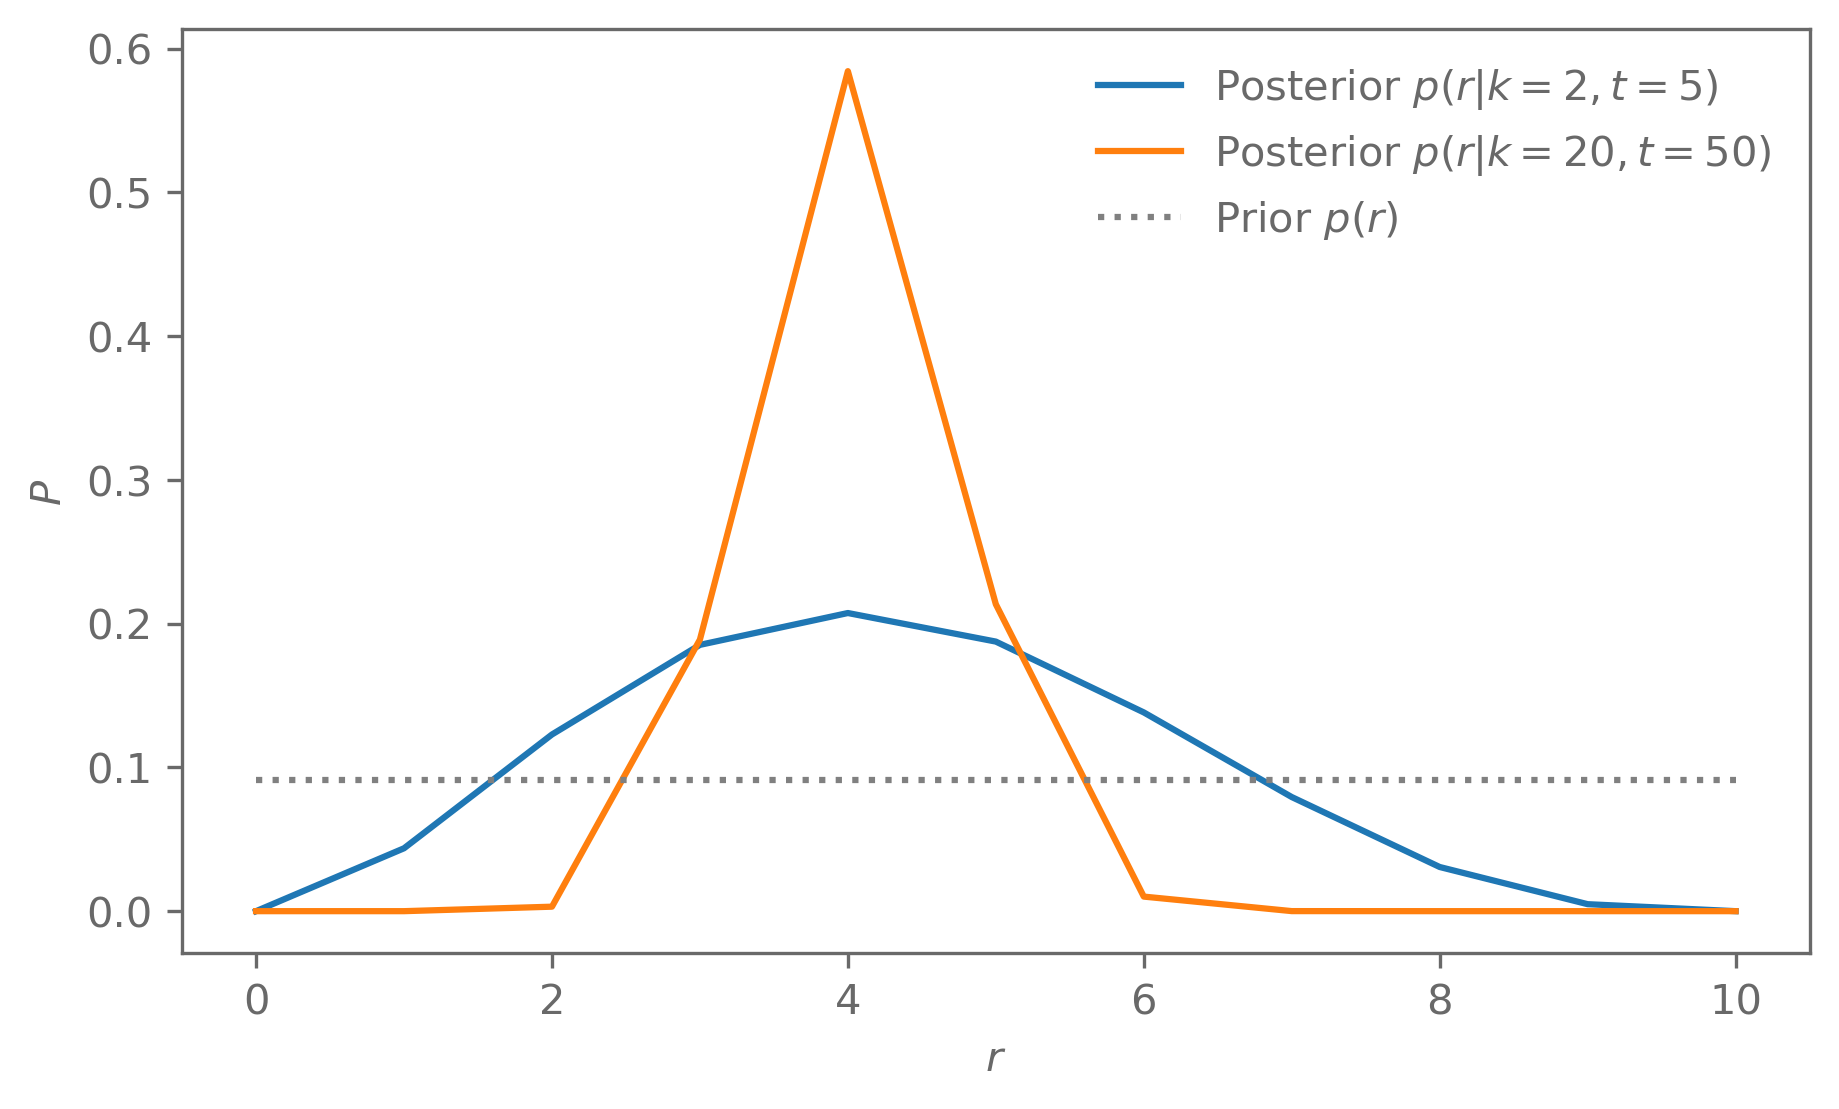

In [94]:
posterior_20_50 = posterior(r, k=20, t=50)
# Normalise the posterior
posterior_20_50 /= posterior_20_50.sum()

plt.plot(r, posterior_2_5, label="Posterior $p(r|k=2, t=5)$")
plt.plot(r, posterior_20_50, label="Posterior $p(r|k=20, t=50)$")
plt.plot(r, prior(r), c="grey", ls=":", label="Prior $p(r)$")
plt.legend(frameon=False)
plt.ylabel("$P$")
plt.xlabel("$r$");

### Updating the prior

The Bayesian formalism allows us to update our prior believes once new data comes in. 

Assume we have just finished the experiment where we drew 2 red balls in 5 trials.

If we now do a new experiment (using the same urn), we can use our knowledge from the previous experiment to update our prior on the number of red balls in the urn.

For example, we can use the posterior from the previous experiment as the prior.

What is the posterior on $r$ after the 2nd experiment where you draw $k=6$ red balls in $t=12$ trials, using the previous posterior distribution as the prior?

In [95]:
def updated_prior(r):
    return posterior(r, k=2, t=5)

def updated_posterior(r, k, t):
    return likelihood(k, t, r) * updated_prior(r)

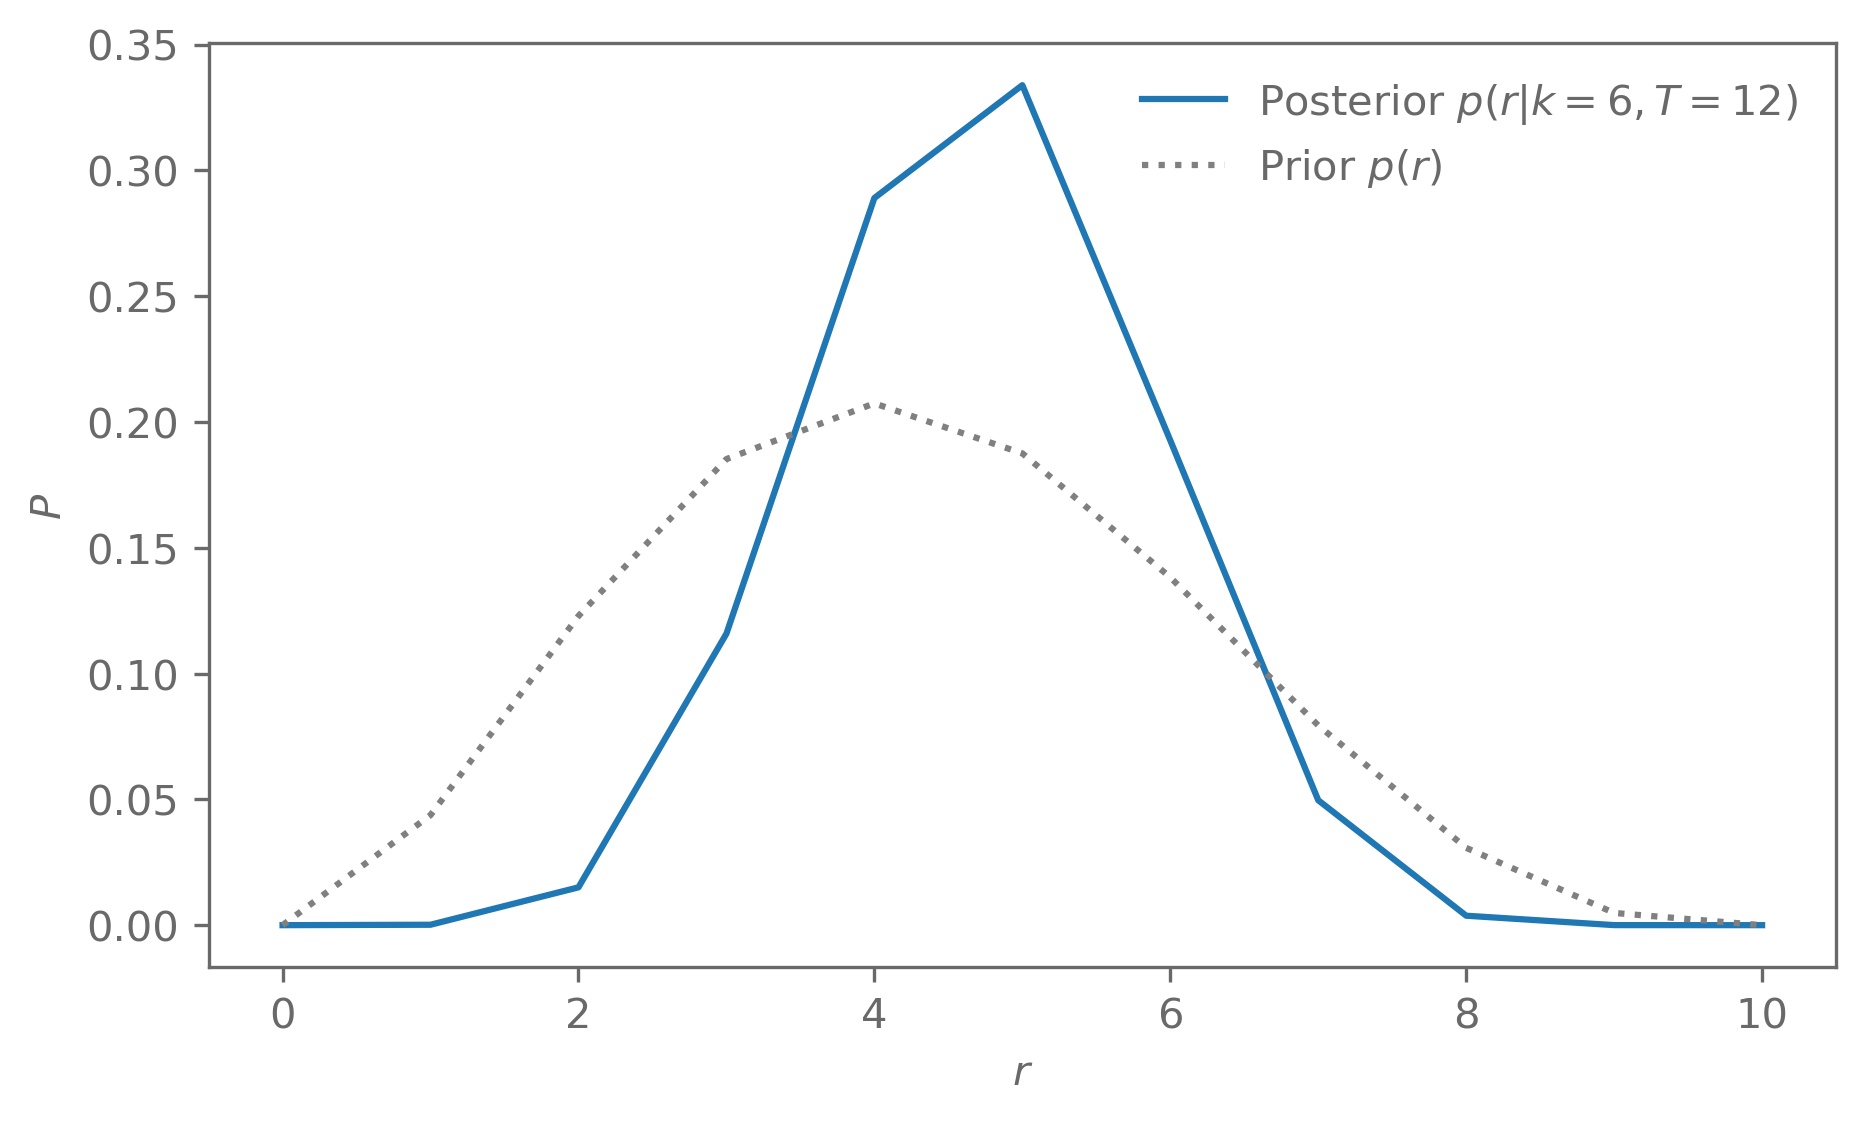

In [96]:
updated_posterior_6_12 = updated_posterior(r, k=6, t=12)
# Normalise
updated_posterior_6_12 /= np.sum(updated_posterior_6_12)

plt.plot(r, updated_posterior_6_12, label="Posterior $p(r|k=6, T=12)$")
plt.plot(r, posterior_2_5, c="grey", ls=":", label="Prior $p(r)$")
plt.legend(frameon=False)
plt.ylabel("$P$")
plt.xlabel("$r$");


## Making predictions

Because the likelihood is a probability distribution of the data, we can use it to sample new data given the model and parameters. 

Before the observed data are considered, the (marginal) distribution of the data is
$$
    p(d) = \int p(d,\theta)\dd\theta = \int p(d|\theta)p(\theta)\dd\theta\ .
$$
In the context of making predictions, this is called the prior predictive distribution: 
- Prior, because it is not conditioned on the observed data
- Predictive, because it is the distribution of a quantity that is observable



It allows us to make predictions of how the observed data will look like under our prior, likelihood, and model. 
Comparing these predictions to the observed data can give us some indication if our priors, likelihoods, and models are reasonable.


As long as we can sample from the prior and from the likelihood, we can create samples from the prior predictive distribution:
1. Create samples $\theta_i$ from the prior
2. Sample new data from the likelihood, at parameter $\theta_i$: $\tilde d_i\sim p(\cdot | \theta_i)$

Our priors are usually simple enough to allow easy sampling. 
Because the likelihood describes the data generating process, we can almost always sample from it.

Even if we cannot evaluate the value of the likelihood, we can usually still sample from it.
- For example, a complex simulation of an experiment can simulate data but writing down a closed form for the probability density function $p(d|\theta)$ is impossible.

Once we have observed our actual data and found our posterior $p(\theta|d_\mathrm{obs})$, we can predict new data $\tilde d$, based on the data we just observed.

The posterior predictive distribution is

\begin{equation}
    \begin{split}
        p(\tilde d | d_\mathrm{obs}) &= \int p(\tilde d, \theta | d_\mathrm{obs})\dd \theta \\
        &= \int p(\tilde d | d_\mathrm{obs}, \theta)p(\theta|d_\mathrm{obs})\dd \theta \\
        &= \int p(\tilde d | \theta)p(\theta|d_\mathrm{obs})\dd \theta\,,
    \end{split}
\end{equation}

where we assumed $\tilde d$ and $d_\mathrm{obs}$ are conditionally independent given $\theta$: $p(\tilde d, d_\mathrm{obs} | \theta) = p(\tilde d | \theta)p(d_\mathrm{obs} | \theta)$.

We can sample from it similarly to the prior predictive distribution we saw before. Instead of sampling $\theta_i$ from the prior, we sample it from posterior $p(\theta | d_\mathrm{obs})$:
1. Create samples $\theta_i\sim p(\cdot | d_\mathrm{obs})$
2. Sample new data from the likelihood, at parameter $\theta_i$: $\tilde d_i\sim p(\cdot | \theta_i)$



The posterior predictive distribution comes in handy:
- Check that our model for the data actually agrees with the observed data. This is an important step in Bayesian analysis: the nicest posteriors on parameters are worthless if the parameters do not actually describe the data.
- Predict future observations: imaging we have some time-series data. Once we have conditioned our model on the observed data, we can predict how future data will look.


Often we are in the situation where we have an underlying model $f(\theta)$ and the observed data scatter around this model, described by the likelihood.

For example, in a Gaussian likelihood with fixed variance $\sigma^2$, $f(\theta)$ would give the mean and the data would be distributed as $d\sim\Norm(f(\theta), \sigma^2)$.

In our analysis we might want to know the posterior distribution of the model $f(\theta)$, in addition to the distribution of just the parameters $\theta$.

The posterior distribution of the model is a variant of the prior and posterior predictive distributions and is sometimes called translated predictive distrution.

We sample from it by drawing samples $\theta_i$ from the posterior and evaluating the $f(\theta_i)$. 

This essentially corresponds to assuming a Dirac delta for the likelihood.


## Model comparison

Suggested reading: Information Theory, Inference, and Learning Algorithms, chapter 28

So far all the expressions implicitly assumed a model for how the parameters and data are connected. 

But what if there are multiple plausible models? How do we choose among the models?



Bayesian statistics gives a clear answer to this. Let us first write out Bayes' theorem but now explicitly include that everything depends on the underlying model $M$:
$$
    p(\theta|d, M) = \frac{p(d|\theta, M)p(\theta|M)}{p(d|M)}\ .
$$
What we now want to know is the probability of the model $M$, given the data:
$$
    p(M|d) = \frac{p(d|M)p(M)}{p(d)}
$$



If we have two models $M_1$ and $M_2$, we look at the ratio of their posteriors, called the Bayes' ratio:
$$
    \frac{p(M_1|d)}{p(M_2|d)} = \frac{p(d|M_1)}{p(d|M_2)}\frac{p(M_1)}{p(M_2)}
$$

The odds of model $M_1$ being true compared to model $M_2$ is given by the ratio of the evidences $\frac{p(d|M_1)}{p(d|M_2)}$ times the ratio of the priors of the models. 
If we assume both models to be equally like apriori, the Bayes ratio is just the ratio of the evidences.

Computing the evidence $p(d)$ is challenging in general. We will come back to this once we looked at nested sampling, which is one possible approach to compute it.

## Fitting a line

To see how all these concepts work a bit more in practice, let us fit a line to some data. 
For a polemic view on this topic, see https://arxiv.org/abs/1008.4686.

Take a look at the data in `lectures/data/linear_fits/data_0.txt`

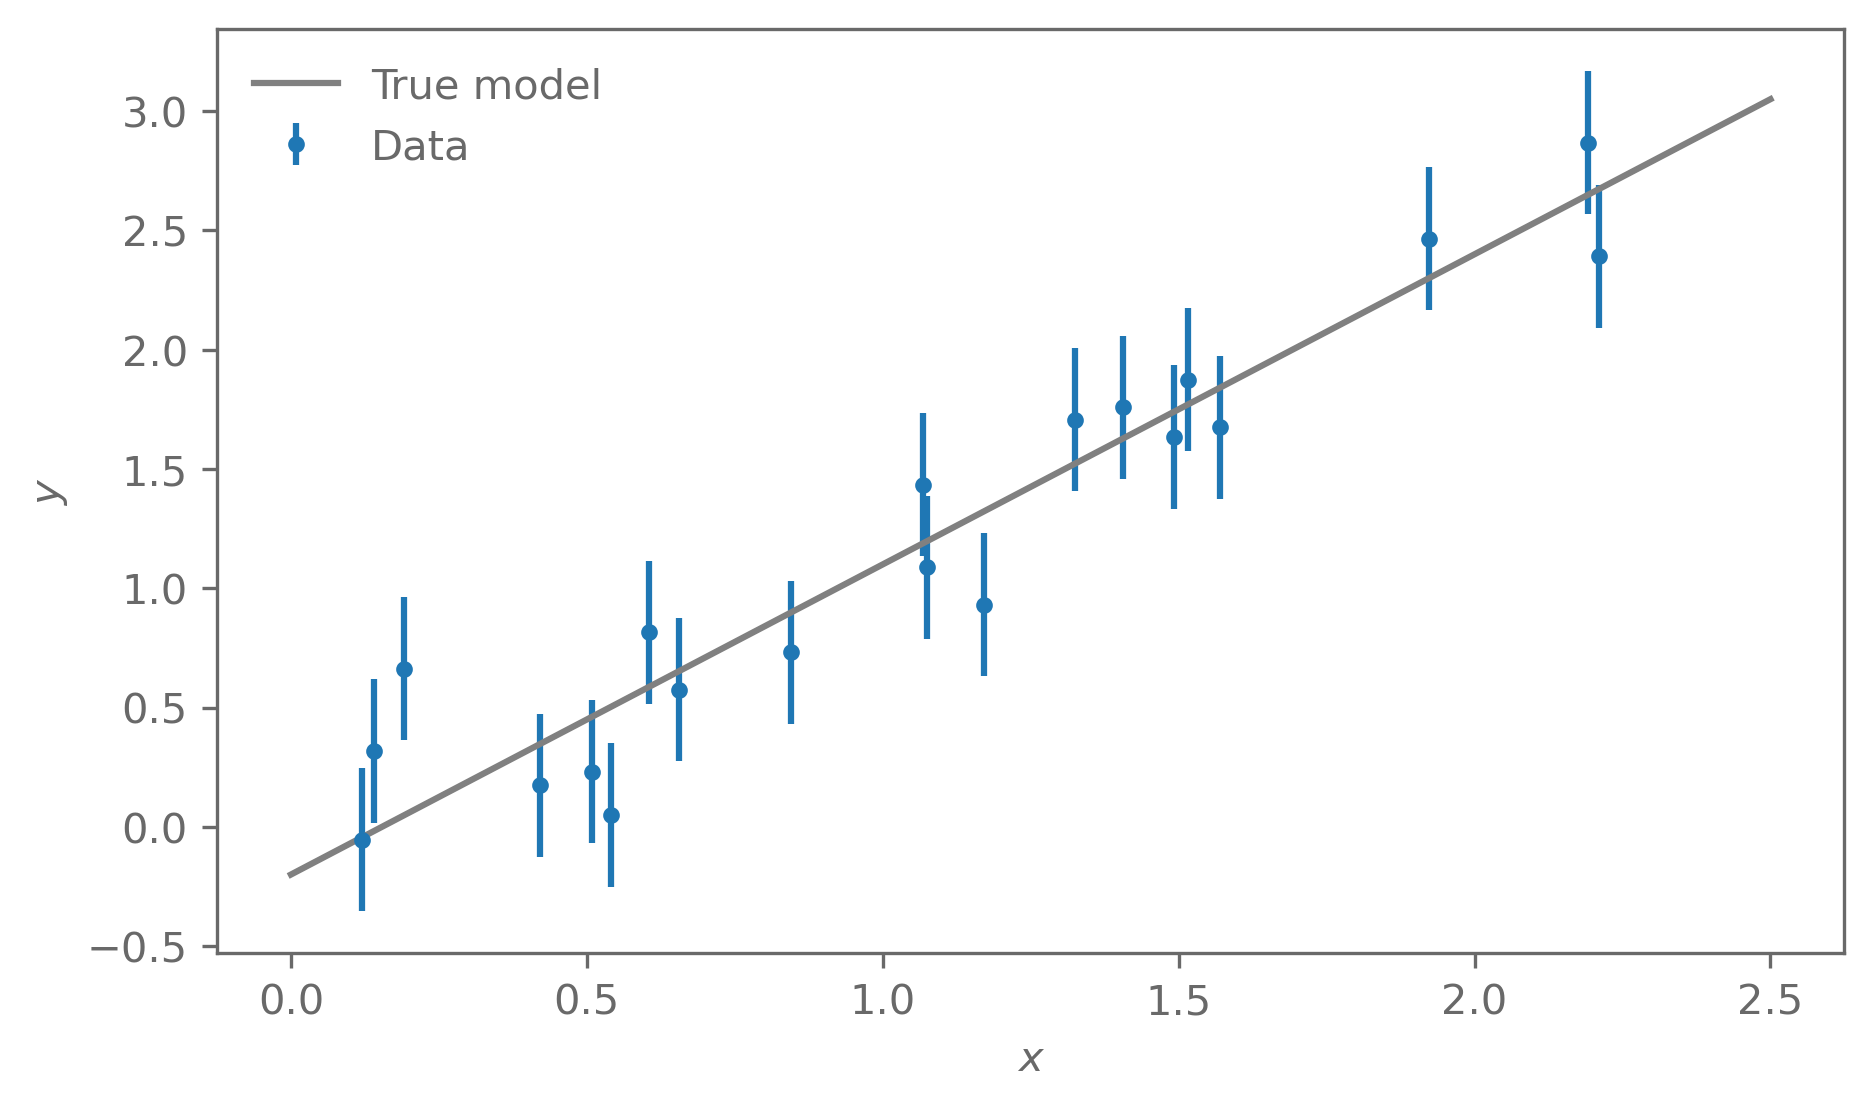

In [98]:
m_true = 1.3
b_true = -0.2

x, y, y_err = np.loadtxt("data/linear_fits/data_0.txt", unpack=True)
# For now, all errors are the same
sigma_y = y_err[0]

plt.errorbar(x, y, y_err, fmt=".", label="Data")
x_grid = np.linspace(0, 2.5, 100)
plt.plot(x_grid, m_true*x_grid + b_true, c="grey", label="True model")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend(frameon=False);

### Bayesian workflow

Let us recall the steps of the Bayesian data analysis workflow:

1. Build a probabilistic model
2. Fit model to the data
3. Check the model

### 1. Build a probabilistic model

Let us assume the following model for the data:

The data $y_i$ are Gaussian distributed around a linear model $f(x) = mx + b$, with a constant variance $\sigma_y^2$:

\begin{align}
    \mu(m, b, x) &= mx + b \\
    y_i&\sim\Norm\left(\mu(m, b, x_i),\sigma_y^2\right)
\end{align}


This lets us define the likelihood:

In [99]:
def model(m, b, x):
    return m*x + b

# We use the logarithm here for computational reasons
def log_likelihood(y, m, b, x, sigma_y):
    prediction = model(m, b, x)

    n = len(y)
    return (
        -0.5 * np.sum((y - prediction)**2/sigma_y**2)  # Exponent
        - n/2*np.log(2*np.pi*sigma_y**2)               # Normalisation
    )

We also need to define a prior. 

Let us assume that we have some prior knowledge:
- $m$ should be around 1 with uncertainty 1: $m\sim\Norm(1, 1)$
- $b$ should be around 0 with uncertainty 1.2: $b\sim\Norm(0, 1.2^2)$

In [100]:
def log_prior(m, b):
    mu_m = 1
    mu_b = 0

    sigma_m = 1
    sigma_b = 1.2

    return (
        -0.5*(m-mu_m)**2/sigma_m**2      # m exponent
        -0.5*(b-mu_b)**2/sigma_b**2      # b exponent
        - 0.5*np.log(2*np.pi*sigma_m**2) # Normalisation
        - 0.5*np.log(2*np.pi*sigma_b**2) # Normalisation
    )

Finally, the unnormalised posterior is the product of the two:

In [101]:
def log_posterior(m, b, x, sigma_y, y):
    return log_likelihood(y, m, b, x, sigma_y) + log_prior(m, b)

### 2. Fit the model

#### MAP

We now defined our posterior, so we can start calculating things with it.

A first step might be to ask, what is the most probable set of parameters $(m, b)$ that describe the data?

For this we need to find the maximum of the posterior. This is called the maximum a-posteriori (MAP) and is the "best-fit" value:
$$
    \theta_\mathrm{MAP} = \underset{\theta}{\mathrm{argmax}}\ p(\theta|d)
$$

In [102]:
# The scipy minimizer finds the minimum, so we need to take the 
# negative of the posterior. The scipy minimizer also passes an array 
# with the parameters, this wrapper splits this array into m and b.
def negative_log_posterior(theta, x, sigma_y, y):
    m, b = theta
    return -log_posterior(m, b, x, sigma_y, y)

MAP_result = scipy.optimize.minimize(
    fun=negative_log_posterior,
    x0=(1, 0),
    args=(x, sigma_y, y)
)
m_MAP, b_MAP = MAP_result.x
print("MAP results")
print(f"m_MAP = {m_MAP:.3f}, b_MAP = {b_MAP:.3f}")
print(f"m_true = {m_true:.3f}, b_true = {b_true:.3f}")

MAP results
m_MAP = 1.251, b_MAP = -0.145
m_true = 1.300, b_true = -0.200


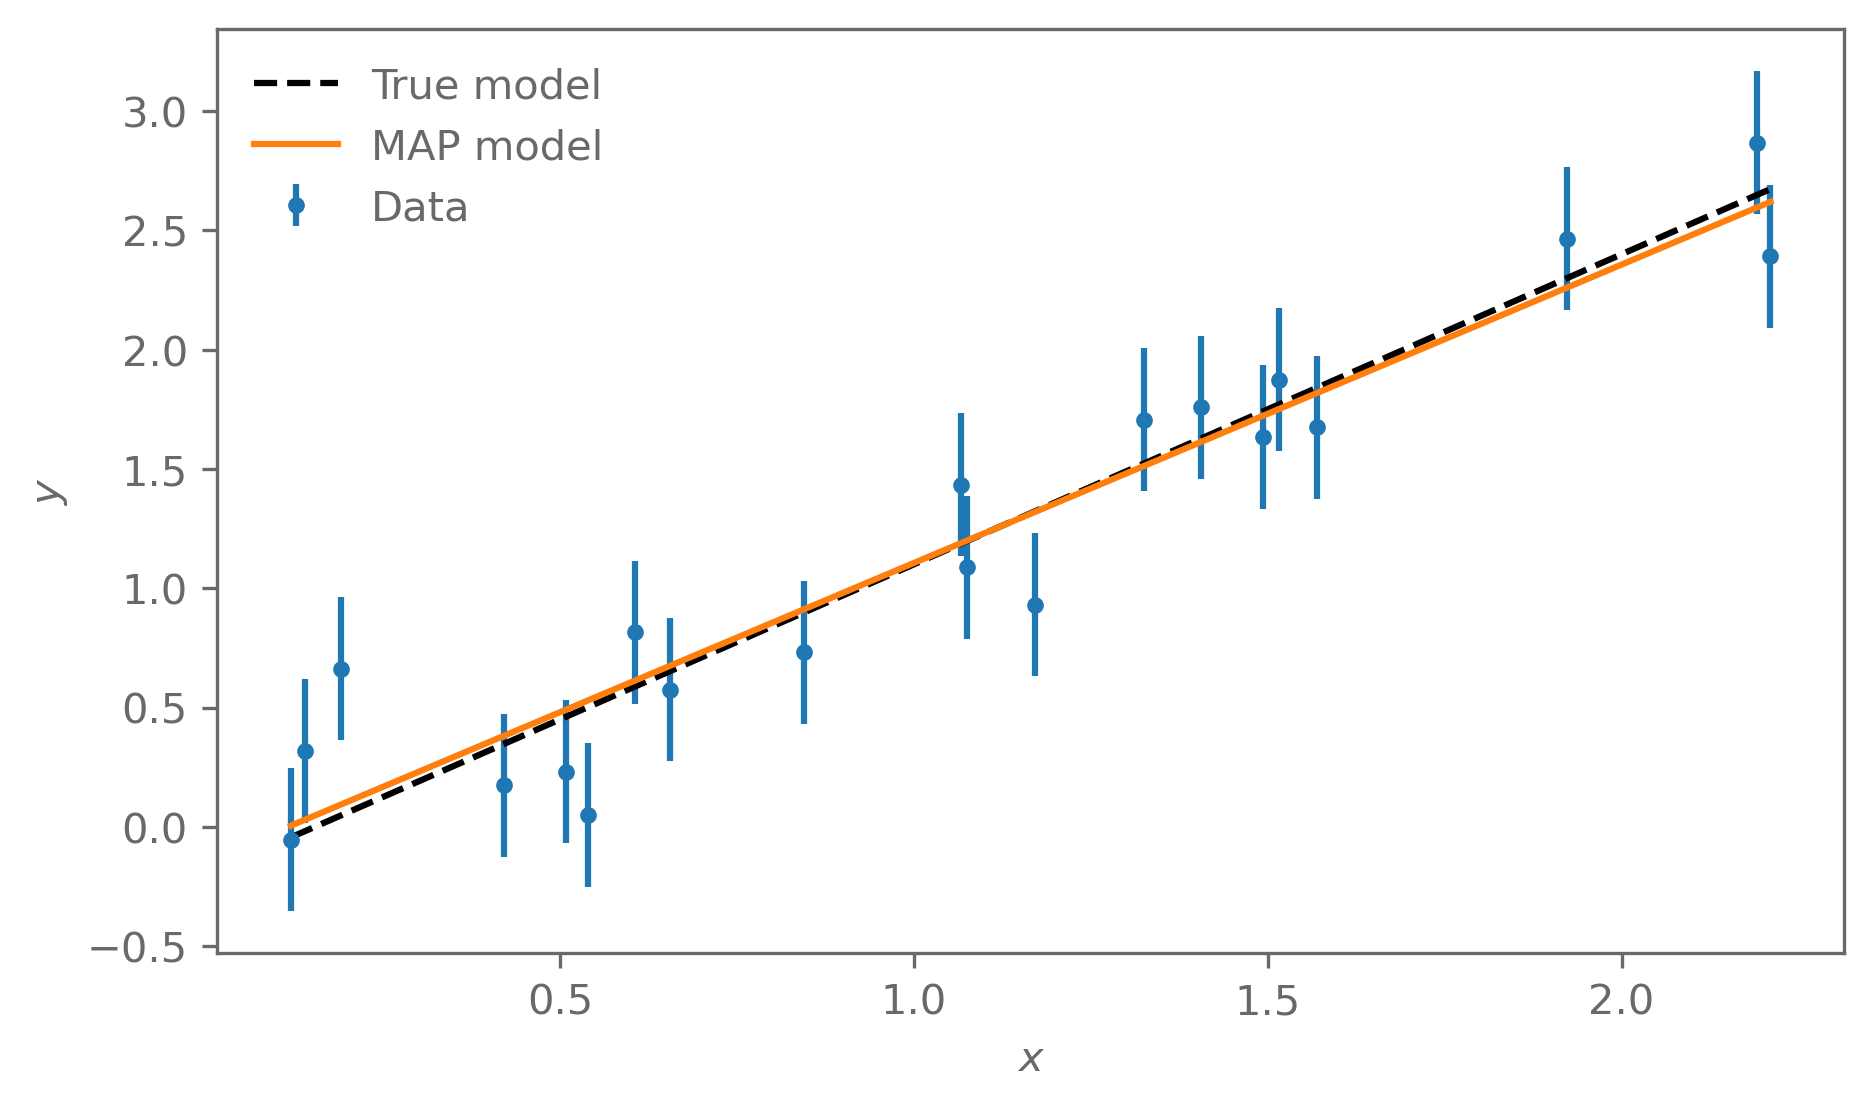

In [103]:
plt.errorbar(x, y, y_err, fmt=".", label="Data")
x_grid = np.linspace(0, 2.5, 100)
plt.plot(x, model(m_true, b_true, x), c="k", ls="--", label="True model")

plt.plot(x, model(m_MAP, b_MAP, x), c="C1", label="MAP model")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend(frameon=False);

#### Sampling the posterior

The MAP only tells us about the mode of the posterior. 

In Bayesian statistics we care about the whole probability structure.

To get there, we need to create samples from the posterior. 

In this specific example there would be an analytic expression for the posterior but in general that is not the case!

In [104]:
import emcee

# emcee passes an array of values for the sampled parameters
# This wrapper just splits the array theta into m and b
def log_posterior_wrapper(theta, x, sigma_y, y):
    m, b = theta
    return log_posterior(m, b, x, sigma_y, y)

# emcee requires some extra settings to run
n_param = 2       # Number of parameter we are sampling
n_walker = 10     # Number of walkers. This just needs to be 
                  # larger than 2*n_param + 1
n_step = 5000     # How many steps each walker will take. The number
                  # of samples will be n_walker*n_step

# The starting point for each walker
theta_init = np.array([0.5, 0.5]) \
    + 0.1*np.random.normal(size=(n_walker, n_param))

sampler = emcee.EnsembleSampler(
    nwalkers=n_walker, ndim=n_param,
    log_prob_fn=log_posterior_wrapper,
    args=(x, sigma_y, y)
)
state = sampler.run_mcmc(theta_init, nsteps=n_step)

In [108]:
import corner

# The samples will be correlated, this checks how correlated they are
# We will discuss this once we come to MCMC methods
print("Auto-correlation time:")
for name, value in zip(["m", "b", "f"], sampler.get_autocorr_time()):
    print(f"{name} = {value:.1f}")

# We need to discard the beginning of the chain (a few auto-correlation times)
# to get rid of the initial conditions
chain = sampler.get_chain(discard=300, thin=10, flat=True)

fig = plt.figure()
fig = corner.corner(
    chain,
    bins=40,
    labels=["m", "b"],
    truths=[m_true, b_true],
    levels=1-np.exp(-0.5*np.array([1, 2])**2), # Credible contours corresponding
                                               # to 1 and 2 sigma in 2D
    quantiles=[0.025, 0.16, 0.84, 0.975],
    fig=fig
);
plt.close()

Auto-correlation time:
m = 38.5
b = 32.5


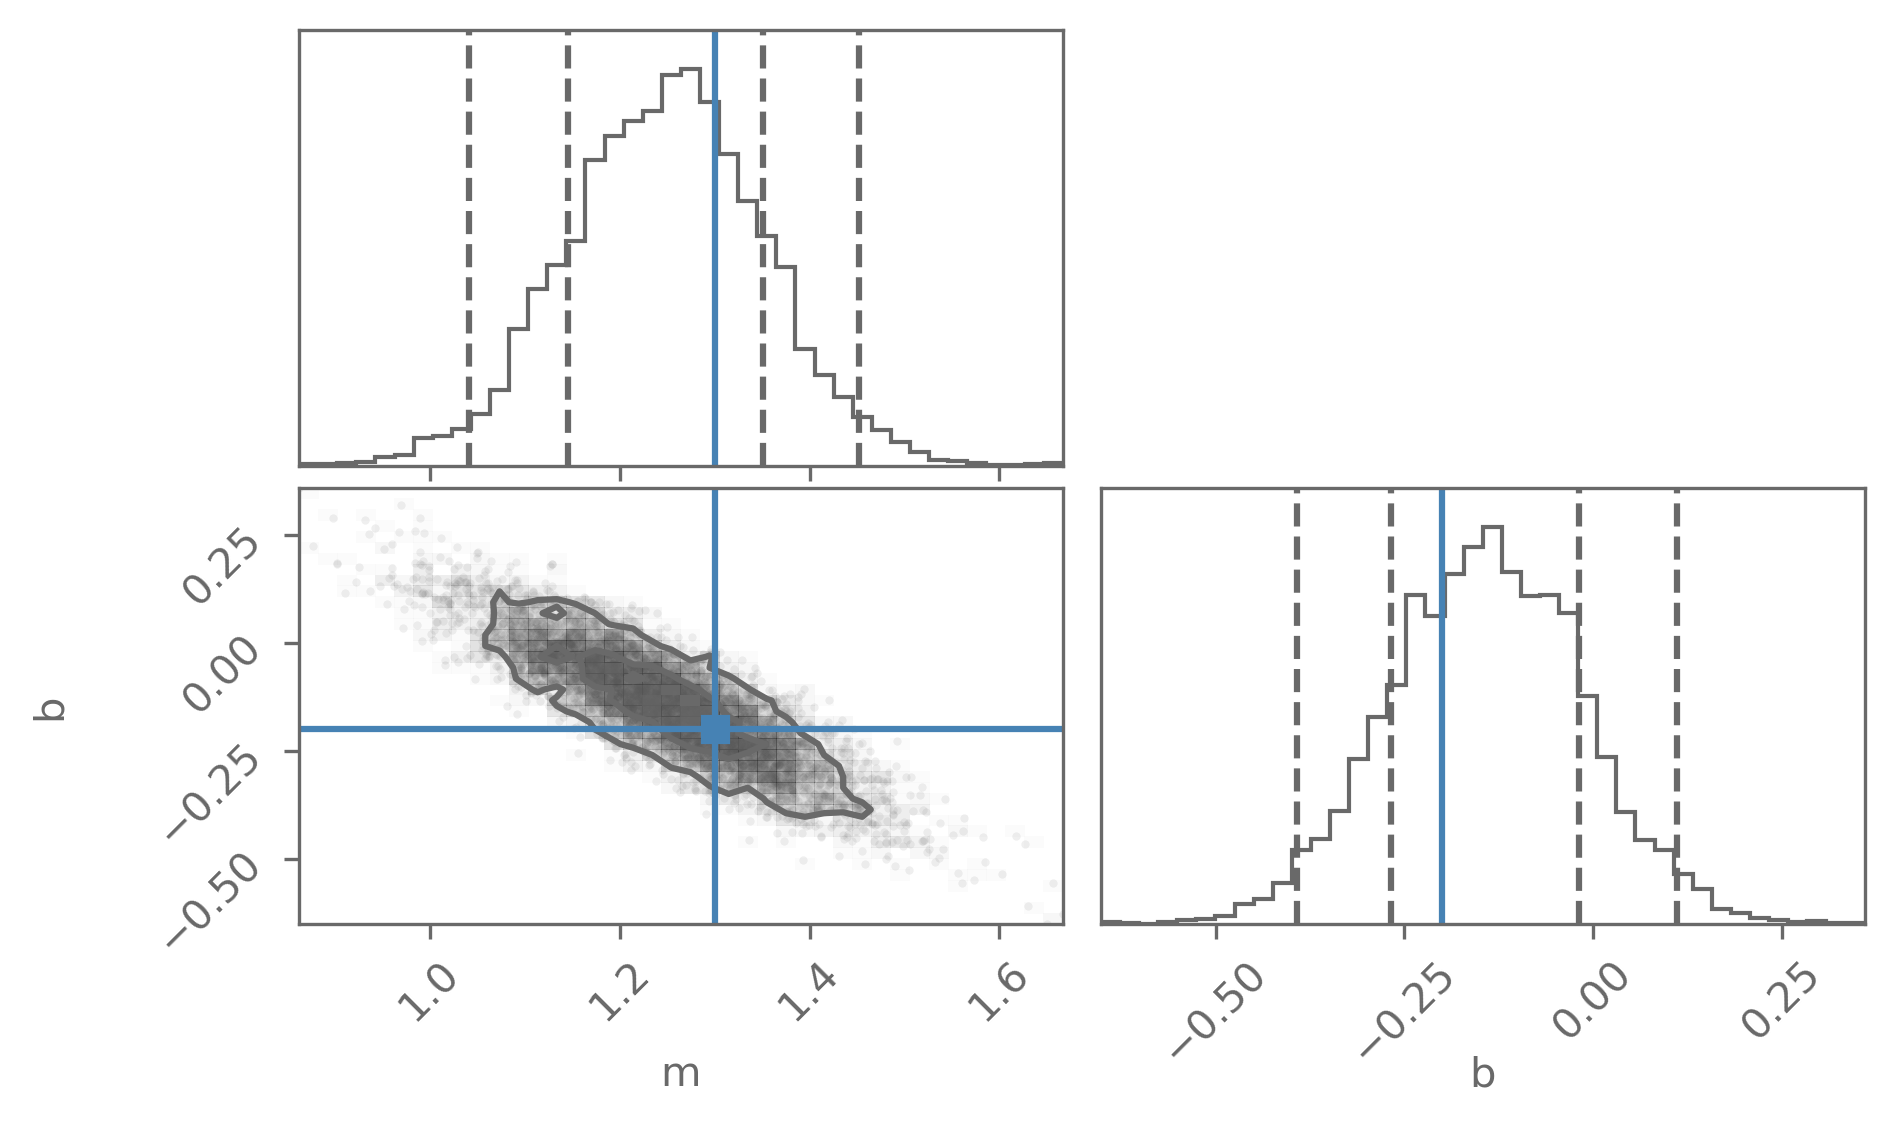

In [109]:
fig

In [110]:
print("Posterior results (mean±std)")
print(f"m = {np.mean(chain[:,0]):.2f}±{np.std(chain[:,0]):.2f}")
print(f"b = {np.mean(chain[:,1]):.2f}±{np.std(chain[:,1]):.2f}")

Posterior results (mean±std)
m = 1.25±0.10
b = -0.14±0.13


### 3. Check the model

#### Making predictions

First, let us look at the uncertainty of the model, given the posterior. 

For this we compute samples of the translated posterior predictive distribution.

In [111]:
# Choose a small subsample of the chain for plotting purposes
chain_samples = chain[np.random.choice(chain.shape[0], size=200)]
# Evaluate the model at the sample parameters
model_predictive = np.array(
    [model(*sample, x) for sample in chain_samples]
)
model_quantiles = np.quantile(
    model_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
)

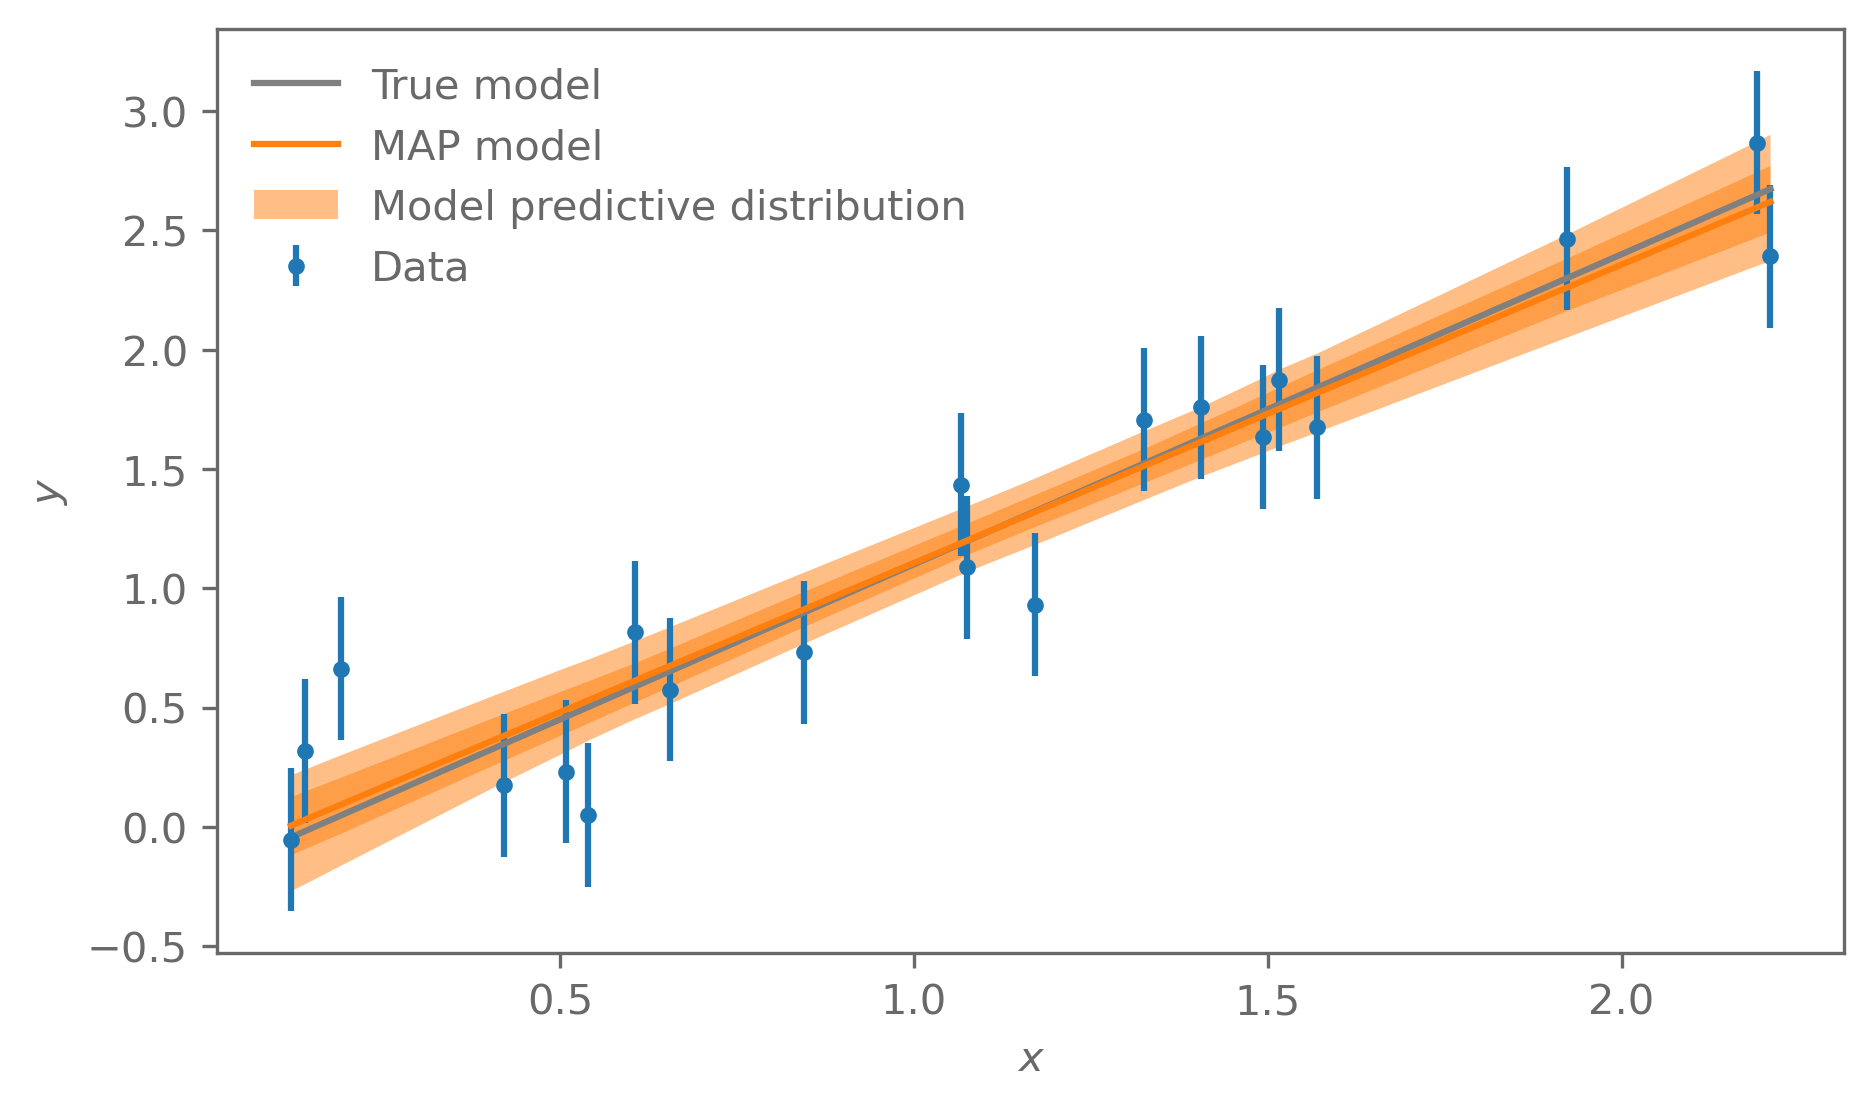

In [112]:
plt.errorbar(x, y, y_err, fmt=".", label="Data")
plt.plot(x, model(m_true, b_true, x), c="grey", label="True model")

plt.plot(x, model(m_MAP, b_MAP, x), c="C1", label="MAP model")
plt.fill_between(x, model_quantiles[0], model_quantiles[-1], alpha=0.5, facecolor="C1",
                 label="Model predictive distribution")
plt.fill_between(x, model_quantiles[1], model_quantiles[-2], alpha=0.5, facecolor="C1")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend(frameon=False);

We can also see if the observed data agree with what the posterior predictive distribution says new data would look like.

In [113]:
# Because we have a Gaussian likelihood with variance \sigma_y^2, we can sample
# from the posterior predictive distribution by adding Gaussian noise with
# variance \sigma_y^2 to the model prediction samples
posterior_predictive = \
    model_predictive + sigma_y*np.random.normal(size=(200,len(x)))

posterior_predictive_quantiles = np.quantile(
    posterior_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
)

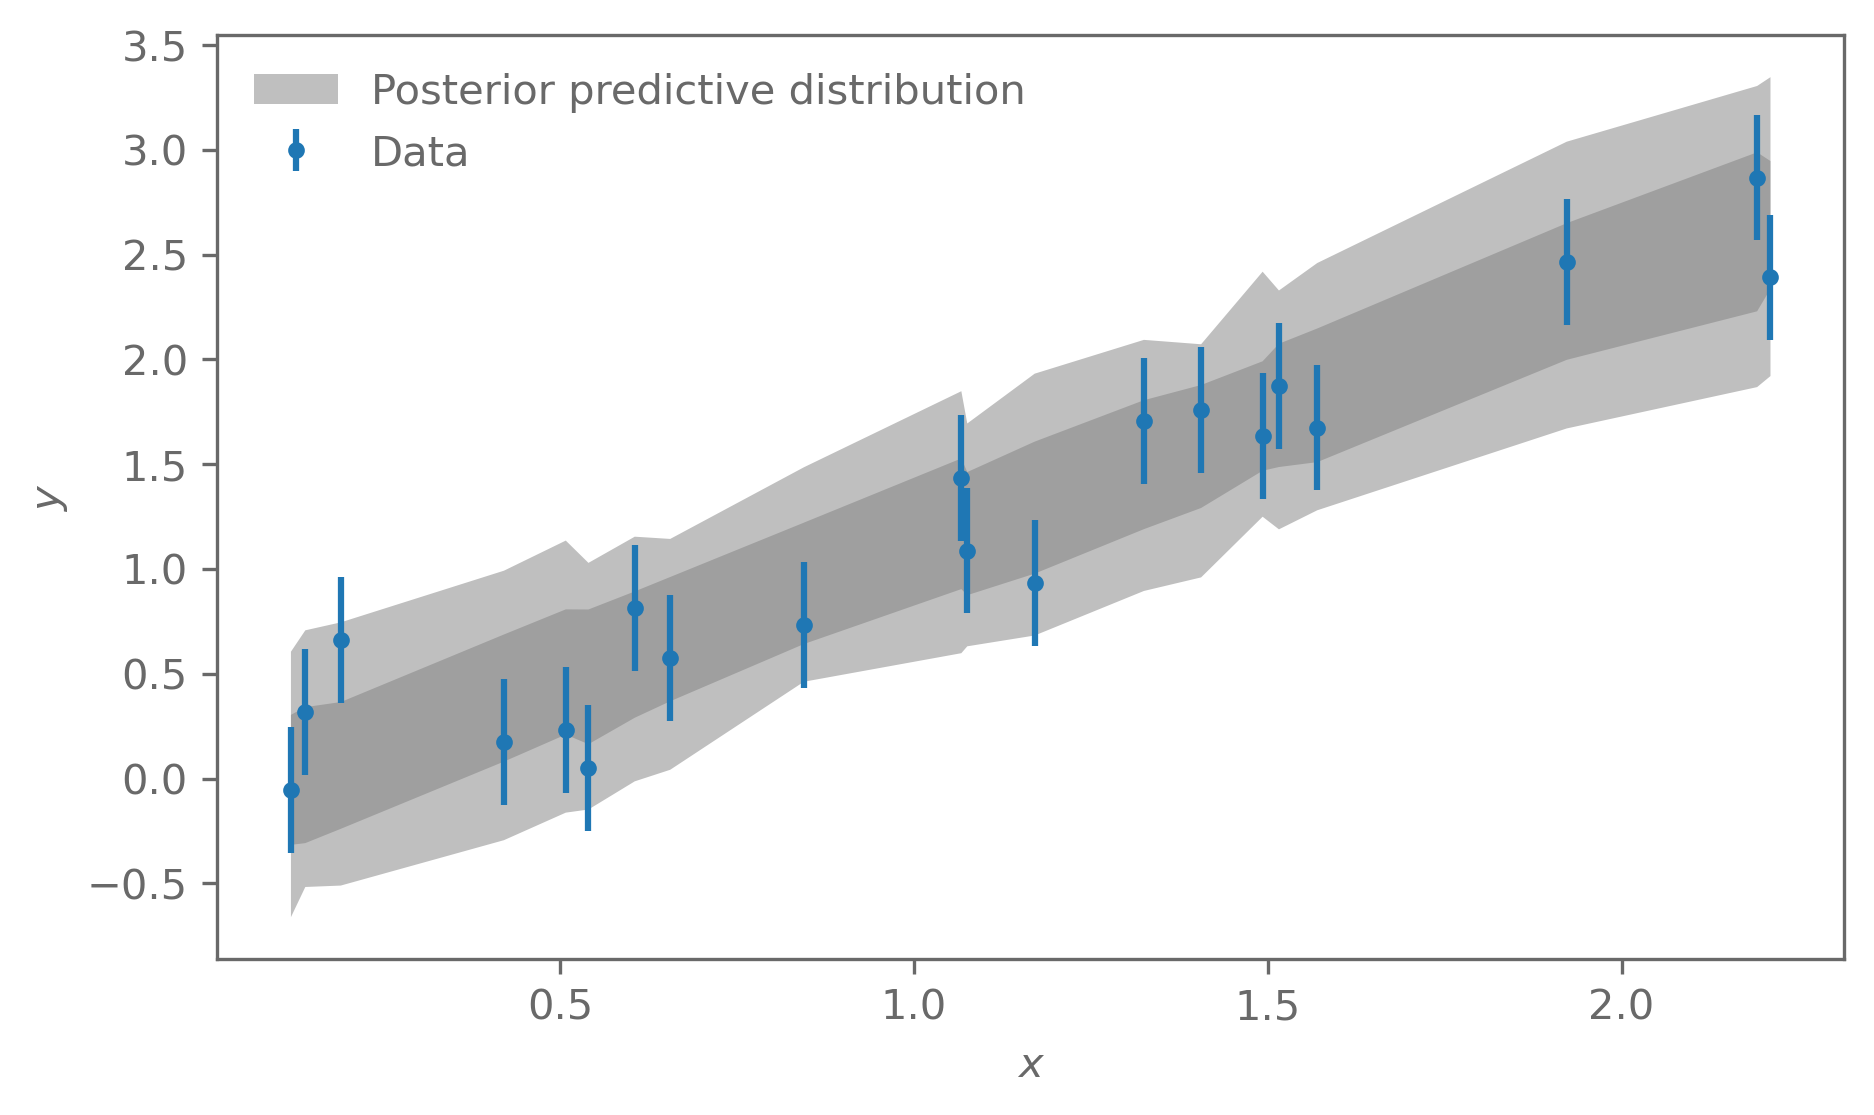

In [114]:

plt.errorbar(x, y, y_err, fmt=".", label="Data")
plt.fill_between(x, posterior_predictive_quantiles[0], posterior_predictive_quantiles[-1],
                 facecolor="grey", alpha=0.5, label="Posterior predictive distribution")
plt.fill_between(x, posterior_predictive_quantiles[1], posterior_predictive_quantiles[-2], facecolor="grey", alpha=0.5)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend(frameon=False);

# Exercise

- Implement your own version of the line-fitting procedure, using the same data.
- Now try it with the data in `lectures/data/linear_fits/data_1.txt`
    - First plot the data. What has changed?
    - Try the same model and likelihood on the new data. You might want to adjust the prior on $m$ and $b$ for this new data set.
    - What if you use the provided uncertainty per data point $\sigma_{y_i}$, instead of assuming a constant variance $\sigma_y$ for all data points?
    - Instead use the actual likelihood of the data:
\begin{align}
    \mu(x) &= mx + b \\
    \sigma(x_i) &= \sigma_{y_i} + f\mu(x_i)^2 \quad f > 0\ \text{a parameter} \\
    y_i&\sim\Norm(\mu(x_i),\sigma(x_i)^2)
\end{align}
Careful with the normalisation of the Gaussian likelihood. Because we vary the variance, this matters now!

## Jovian moons

We now repeat the same workflow on a small but real data set. The goal is to measure Jupiter's mass from observations of its largest moons. 
Kepler's 3rd law relates the orbital period, semimajor axis of the elliptical orbit, and total mass of the system:
$$
T^2 = \frac{4\pi^2}{G(M+m)} a^3\,,
$$
where $T$ is period, $a$ the semi-major axis, $G$ Newton's constant, and $M$ and $m$ the masses of the orbiting bodies. Usually one mass is much larger than the other (e.g. Jupiter and its moons), so $m$ can usually be neglected.

The observations we are going to use were obtained in an AstroWoche project in 2024 by Jonas Spiller, Theo Lequy, Clara Bleich. The observed data are the angular distance between Jupiter and its moons.

<!-- ![jovian moons data](../assets/jovian_moons_raw_data.png) -->
<img style="display: block; 
    margin-left: auto;
    margin-right: auto;
    width: 60%;"
    src="../assets/jovian_moons_raw_data.png" alt="jovian moons data"/>


The Jovian moos we consider (Io, Europa, Ganymede, and Calisto) have very low eccentricity, so we assume a circular orbit. 

Because we can only measure the angular separation between Jupiter and its moons (and not the distance along the line of sight), the observed projected distance $d_\mathrm{proj}$ is
$$
d_\mathrm{proj}(t) = d\sin(\frac{2\pi}{T} t + \phi)\,,
$$
where $d$ is the radius of the orbit and $\phi$ is its phase.

In [132]:
def plot_data(t, distance, distance_err, subtract_y=None):
    fig, ax = plt.subplots()

    if subtract_y is None:
        ax.errorbar(t, distance, distance_err, linestyle="none", marker=".", label="Data")
        ax.set_ylabel("Projected distance to Jupiter [$10^6$ km]")
    else:
        ax.axhline(0, color="dimgrey", lw=1)
        ax.errorbar(t, distance-subtract_y, distance_err, linestyle="none", marker=".", label="Data")
        ax.set_ylabel("Residual projected distance to Jupiter [$10^6$ km]")
    
    ax.set_xlabel("Time since 2024-01-08 18:00 [h]")

    return fig, ax

In [158]:
moon = "Io"

t, distance, distance_alt, distance_err = np.loadtxt(
    f"./data/jovian_moons/{moon}.dat", unpack=True)

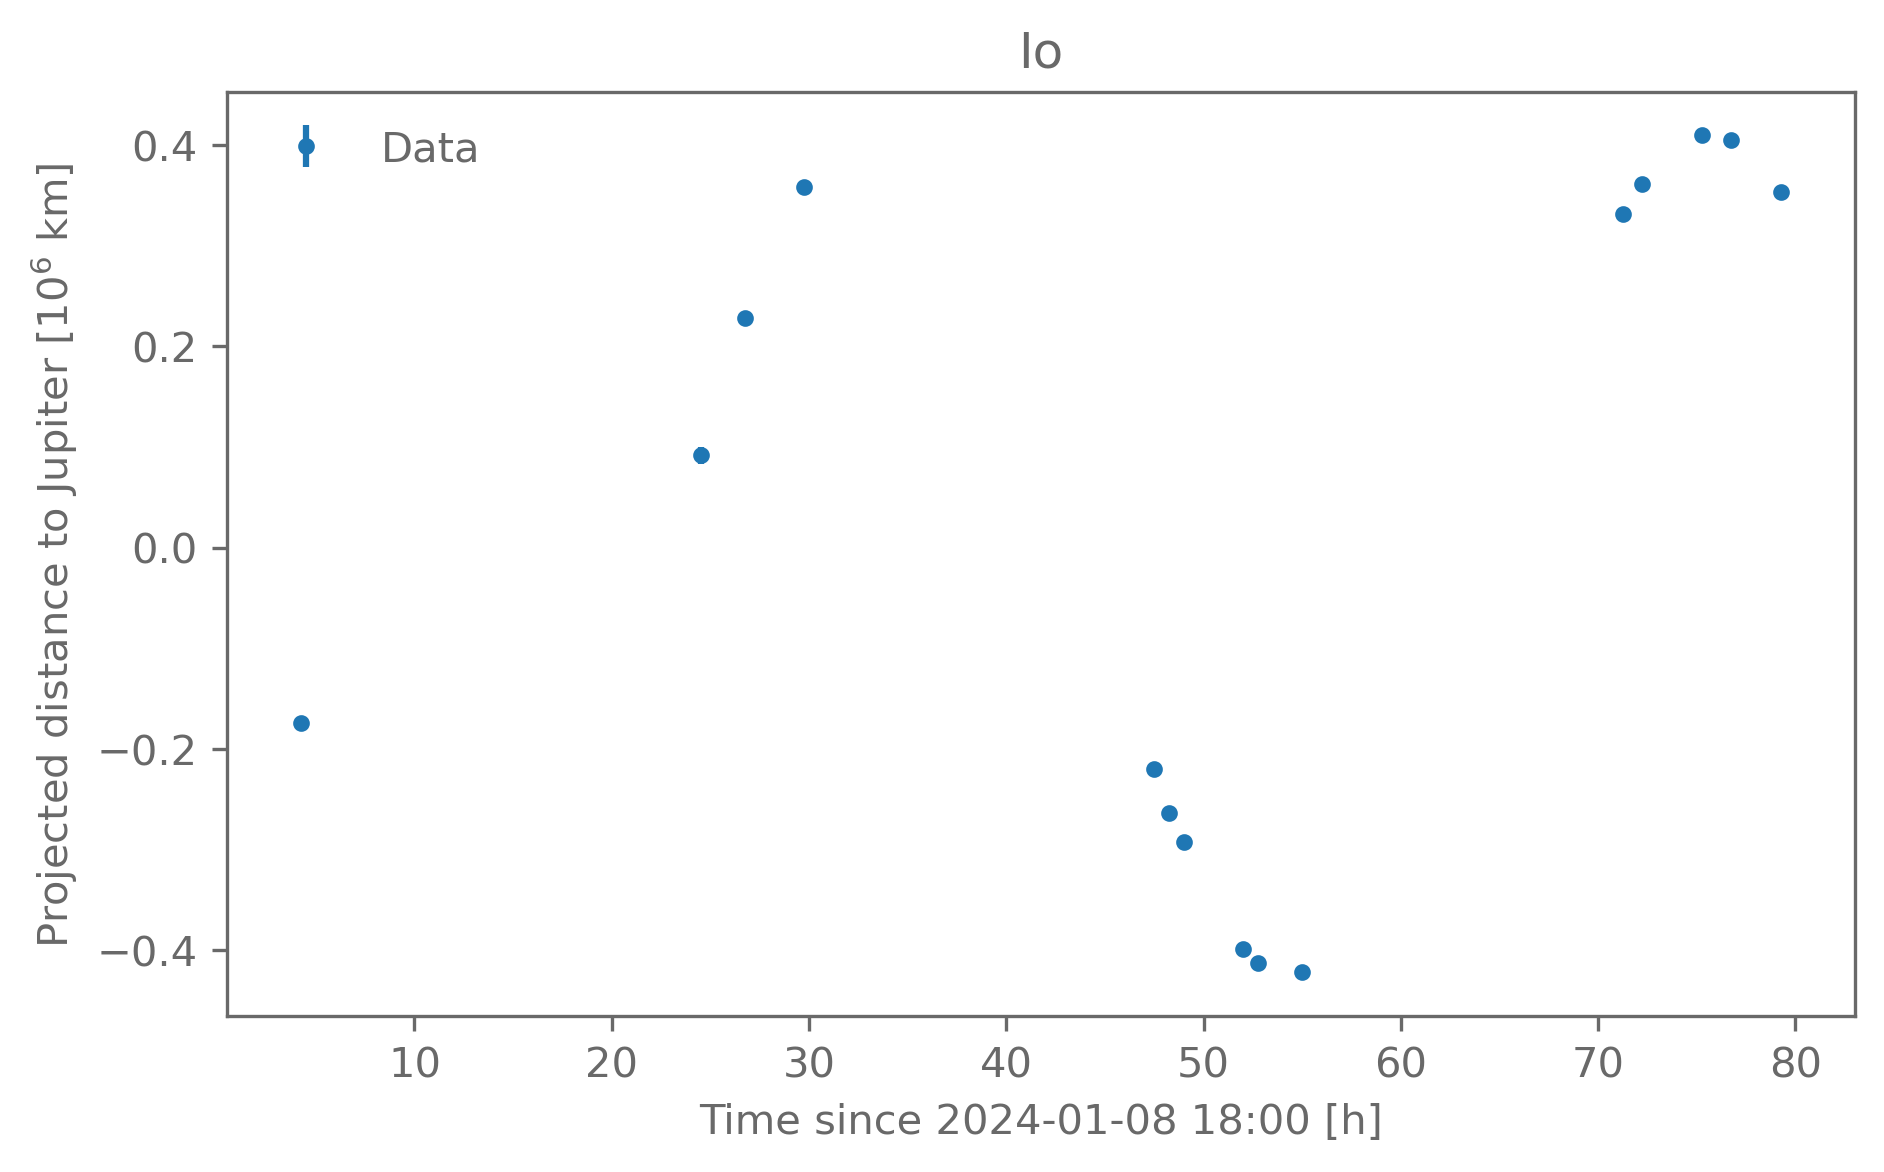

In [159]:
fig, ax = plot_data(t, distance, distance_err)
ax.legend()
_ = ax.set_title(f"{moon}")

### Step 1: Build the model

We assume circular orbits with no inclination and a Gaussian likelihood. The variance of the likelihood is given by the sample variance of the observed distance over 5 exposures.

In [118]:
def model(theta, t):
    semimajor, period, phi = theta
    return semimajor * np.sin(2*np.pi/period * t + phi)


def build_likelihood():
    # Sample new data from the likelihood
    def predict(theta, t, sigma_d):
        mu = model(theta, t)
        return np.random.normal(loc=mu, scale=sigma_d)

    # Evaluate the log-likelihood
    def log_likelihood(d, theta, t, sigma_d):
        mu = model(theta, t)

        n = len(d)
        return (
            -0.5 * np.sum((d - mu)**2/sigma_d**2)  # Exponent
            - 0.5*np.log(2*np.pi) - 0.5*np.sum(np.log(sigma_d**2)) # Normalisation
        )
    
    return predict, log_likelihood

#### Is the model reasonable?

To check if the model seems reasonable a-priori, let us look at the prior predictive distribution: sample parameters from the prior and see what kind of data the model predicts before fitting it to the observed data.

For the prior we try to be quite uninformative. For example
- $a / 10^6\,\mathrm{km} \sim\Uniform(0, 3)$
- $T / \mathrm{h} \sim\Uniform(10, 100)$
- $\phi \sim\Uniform(0, 2\pi)$

In [121]:
def build_prior():
    low_a, high_a = 0.0, 3.0
    low_T, high_T = 10, 100
    low_phi, high_phi = 0, 2*np.pi

    def sample_from_prior(n):
        semimajor = np.random.uniform(low=low_a, high=high_a, size=(n,))
        period = np.random.uniform(low=low_T, high=high_T, size=(n,))
        phase = np.random.uniform(low=low_phi, high=high_phi, size=(n,))

        return np.stack((semimajor, period, phase)).T

    def log_prior(theta):
        semimajor, period, phase = theta
        if (semimajor < low_a or high_a < semimajor
                or period < low_T or high_T < period
                or phase < low_phi or high_phi < phase):
            return -np.inf
        return 0 # ignore normalisation for now

    return sample_from_prior, log_prior

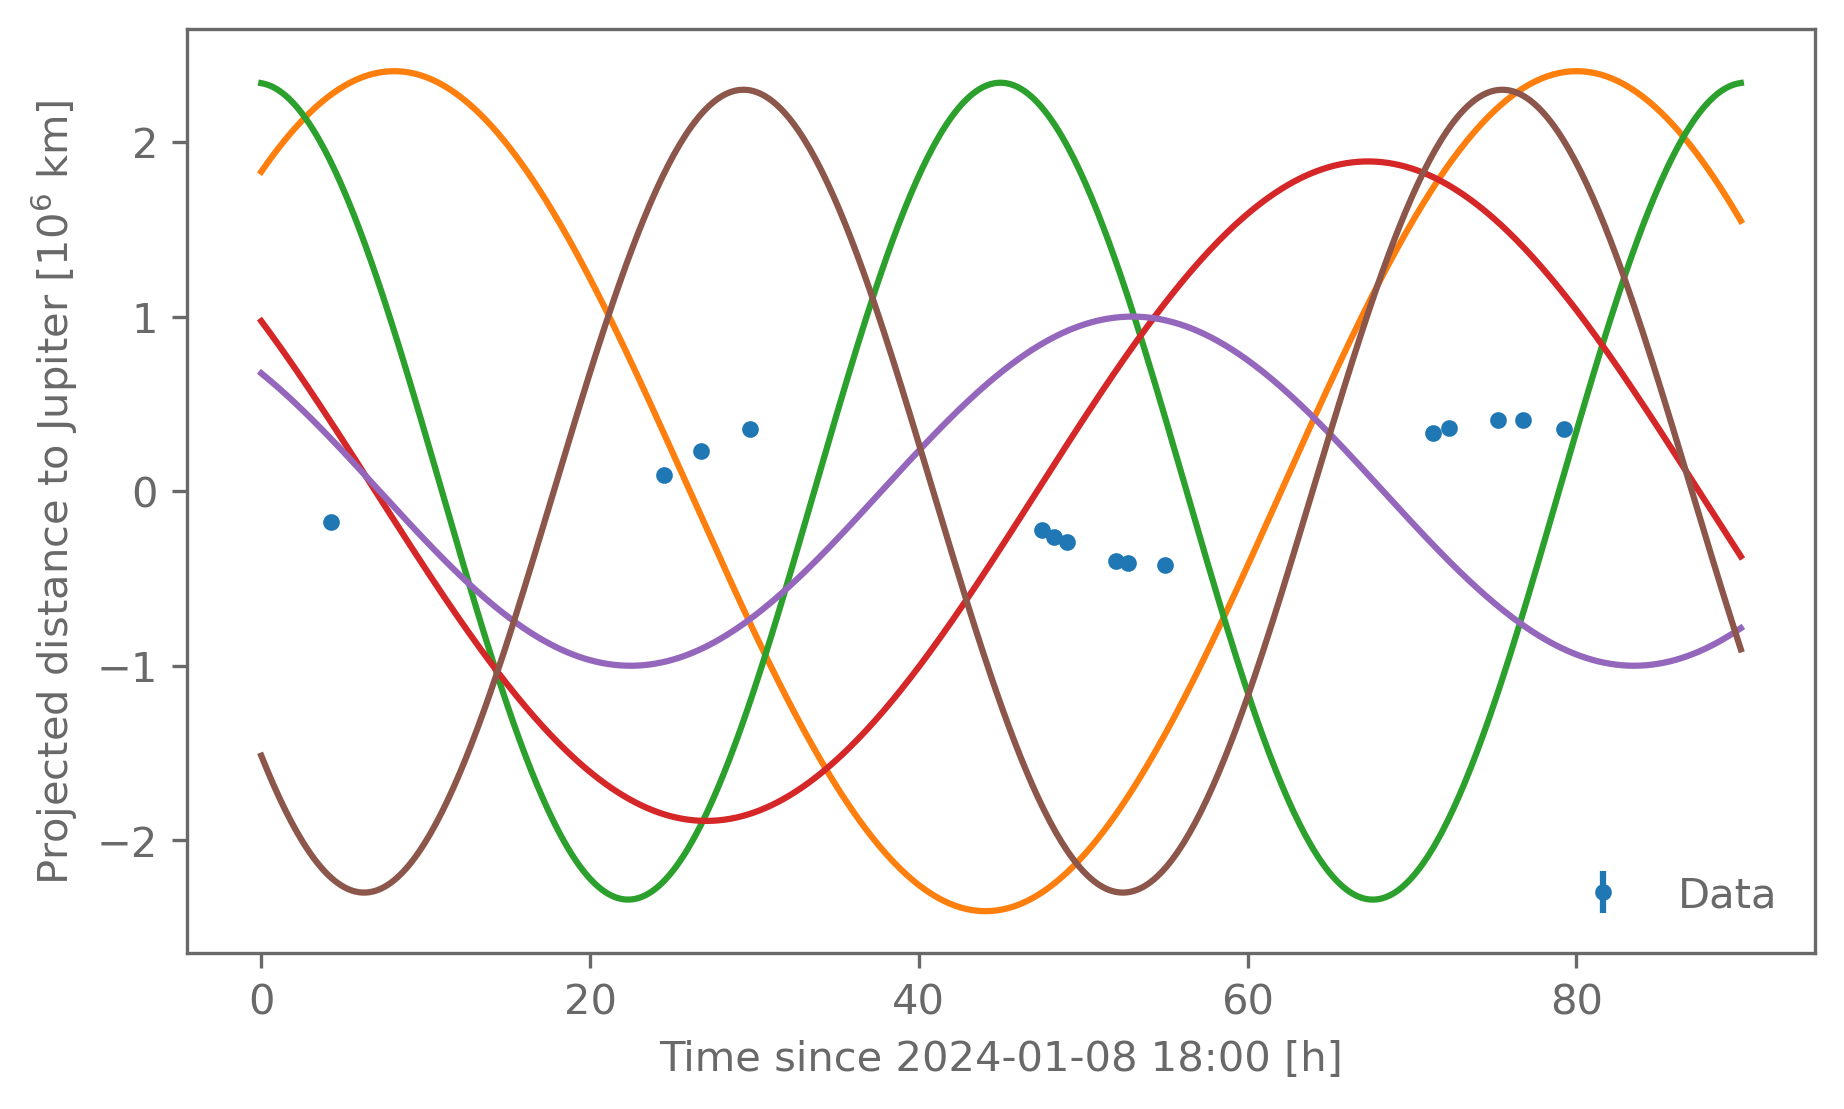

In [136]:
sample_from_likelihood, log_likelihood = build_likelihood()
sample_from_prior, log_prior = build_prior()

t_fine = np.linspace(0, 90, 500)

fig, ax = plot_data(t, distance, distance_err)

for p in sample_from_prior(5):
    ax.plot(t_fine, model(p, t_fine))

_ = ax.legend()

In [162]:
def log_posterior(theta, t, sigma_d, d):
    prior = log_prior(theta)
    if not np.isfinite(prior):
        return prior
    return log_likelihood(d, theta, t, sigma_d) + prior

log_posterior(sample_from_prior(1)[0], t, distance_err, distance)

# Make the output on the slides look nice
import warnings
warnings.filterwarnings('ignore')

### Step 2: Fit the model

First, let us find the best-fitting model parameters.

In [161]:
MAP_result = scipy.optimize.minimize(
    fun=lambda theta: -log_posterior(theta=theta, t=t,
                                     sigma_d=distance_err, d=distance),
    x0=(1.0, 40.0, 1.0),
)
semimajor_MAP, period_MAP, phase_MAP = MAP_result.x
print("MAP results")
print(f"{semimajor_MAP=:.3f}, {period_MAP=:.3f}, {phase_MAP=:.3f}")

MAP results
semimajor_MAP=0.414, period_MAP=42.407, phase_MAP=2.949


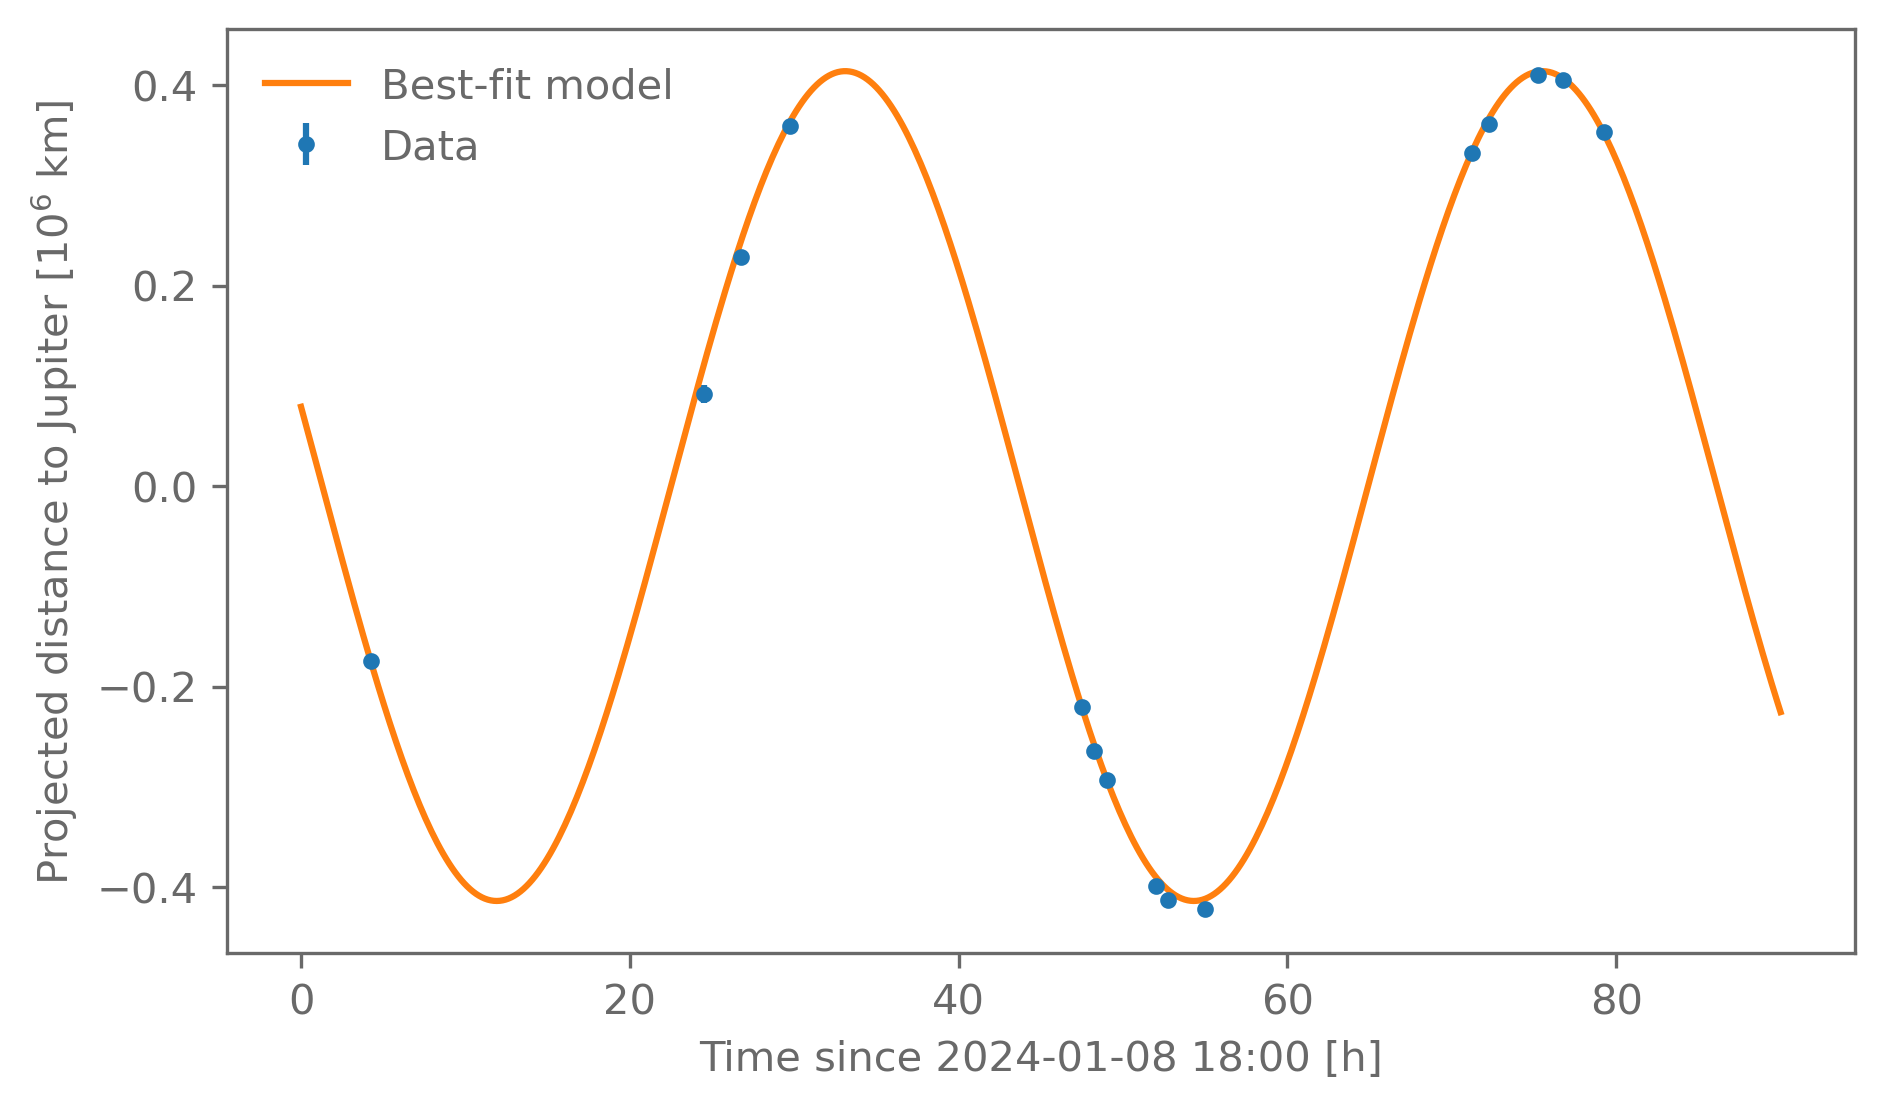

In [142]:
fig, ax = plot_data(t, distance, distance_err)
ax.plot(t_fine, model(MAP_result.x, t_fine), label="Best-fit model")
_ = ax.legend()

#### Sample the posterior

Even though our model is still quite simple, there is no analytic expression for the posterior, so we need to sample it with something like an MCMC method. We use `emcee` again.

In [143]:
n_param = 3
n_walker = 10
n_step = 5000

# The starting point for each walker
theta_init = np.array([0.5, 40.0, 3.0]) \
    + 0.1*np.random.normal(size=(n_walker, n_param))

sampler = emcee.EnsembleSampler(
    nwalkers=n_walker, ndim=n_param,
    log_prob_fn=lambda theta: log_posterior(theta=theta, t=t,
                                            sigma_d=distance_err, d=distance),
)
state = sampler.run_mcmc(theta_init, nsteps=n_step)

Check that the chain has converged

In [144]:
print("Auto-correlation time:")
for name, value in zip(["a", "T", "phi"], sampler.get_autocorr_time()):
    print(f"{name} = {value:.1f}")

# We need to discard the beginning of the chain (a few auto-correlation times)
# to get rid of the initial conditions
chain = sampler.get_chain(discard=300, thin=20, flat=True)

Auto-correlation time:
a = 21.2
T = 61.6
phi = 28.0


We can now compute the mass of Jupiter from the the semi-major axis and period.

In [163]:
def mass_from_Kepler_3rd_law(theta):
    semimajor, period = theta[:2]
    return 4*(np.pi**2)/6.674e-11*((1e9*semimajor)**3)/((period*3600)**2)

mass_Jupiter = mass_from_Kepler_3rd_law(chain.T)
chain_with_mass = np.column_stack((chain, mass_Jupiter))

print("Posterior results (mean±std)")
for i, param in enumerate(["semi-major axis a [10^6 km]", "period T [km]",
                           "phase phi", "mass M [kg]"]):
    mean = np.mean(chain_with_mass[:,i])
    std = np.std(chain_with_mass[:,i])
    print(f"{param} = {mean:.4g} ± {std:.2g}")

Posterior results (mean±std)
semi-major axis a [10^6 km] = 0.4138 ± 0.00037
period T [km] = 42.41 ± 0.023
phase phi = 2.949 ± 0.0046
mass M [kg] = 1.798e+27 ± 5.5e+24


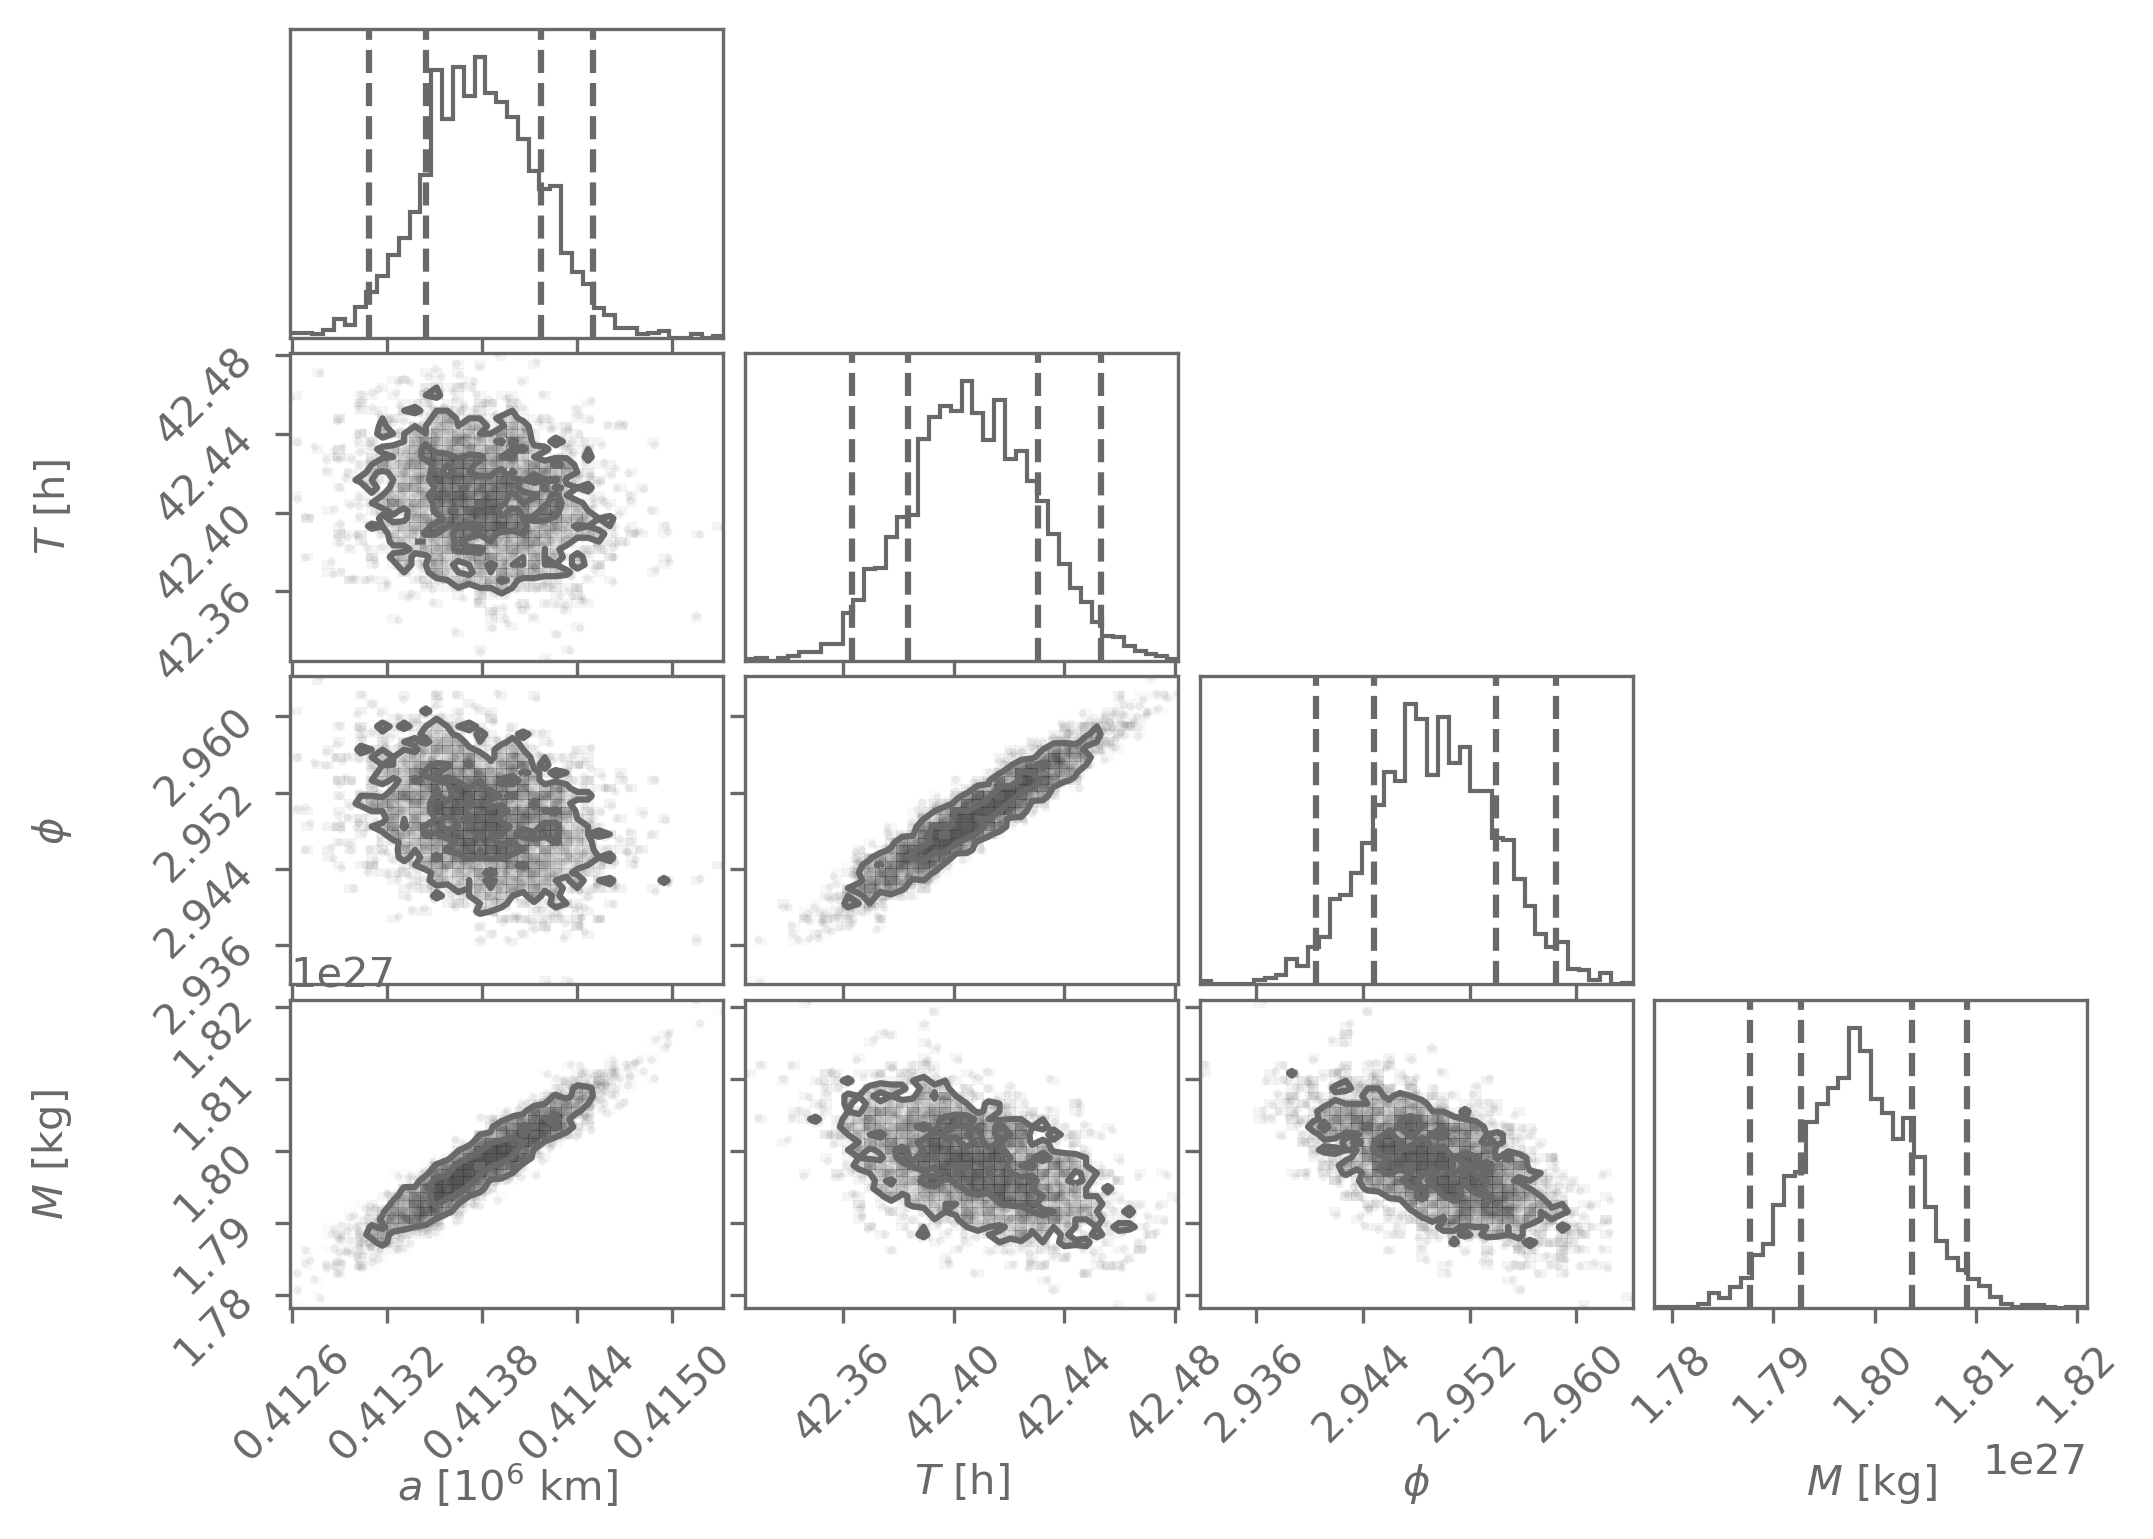

In [172]:
fig = plt.figure(figsize=(7.0, 7.0))
fig = corner.corner(
    chain_with_mass,
    bins=40,
    labels=["$a$ [$10^6$ km]", "$T$ [h]", r"$\phi$", "$M$ [kg]"],
    levels=1-np.exp(-0.5*np.array([1, 2])**2),
    quantiles=[0.025, 0.16, 0.84, 0.975],
    title_quantiles=[0.16, 0.5, 0.84],
    labelpad=0.2,
    fig=fig
);
fig.subplots_adjust(bottom=0.35)
# plt.close()

### Step 3: Check the model

The posterior distribution looks reasonable at first glance. But can our model describe the data?

In [154]:
chain_samples = chain[np.random.choice(chain.shape[0], size=200)]

# Evaluate the model at the sample parameters
model_predictive = np.array(
    [model(theta=sample, t=t_fine) for sample in chain_samples]
)
posterior_predictive = np.array(
    [sample_from_likelihood(theta=sample, t=t, sigma_d=distance_err)
     for sample in chain_samples]
)

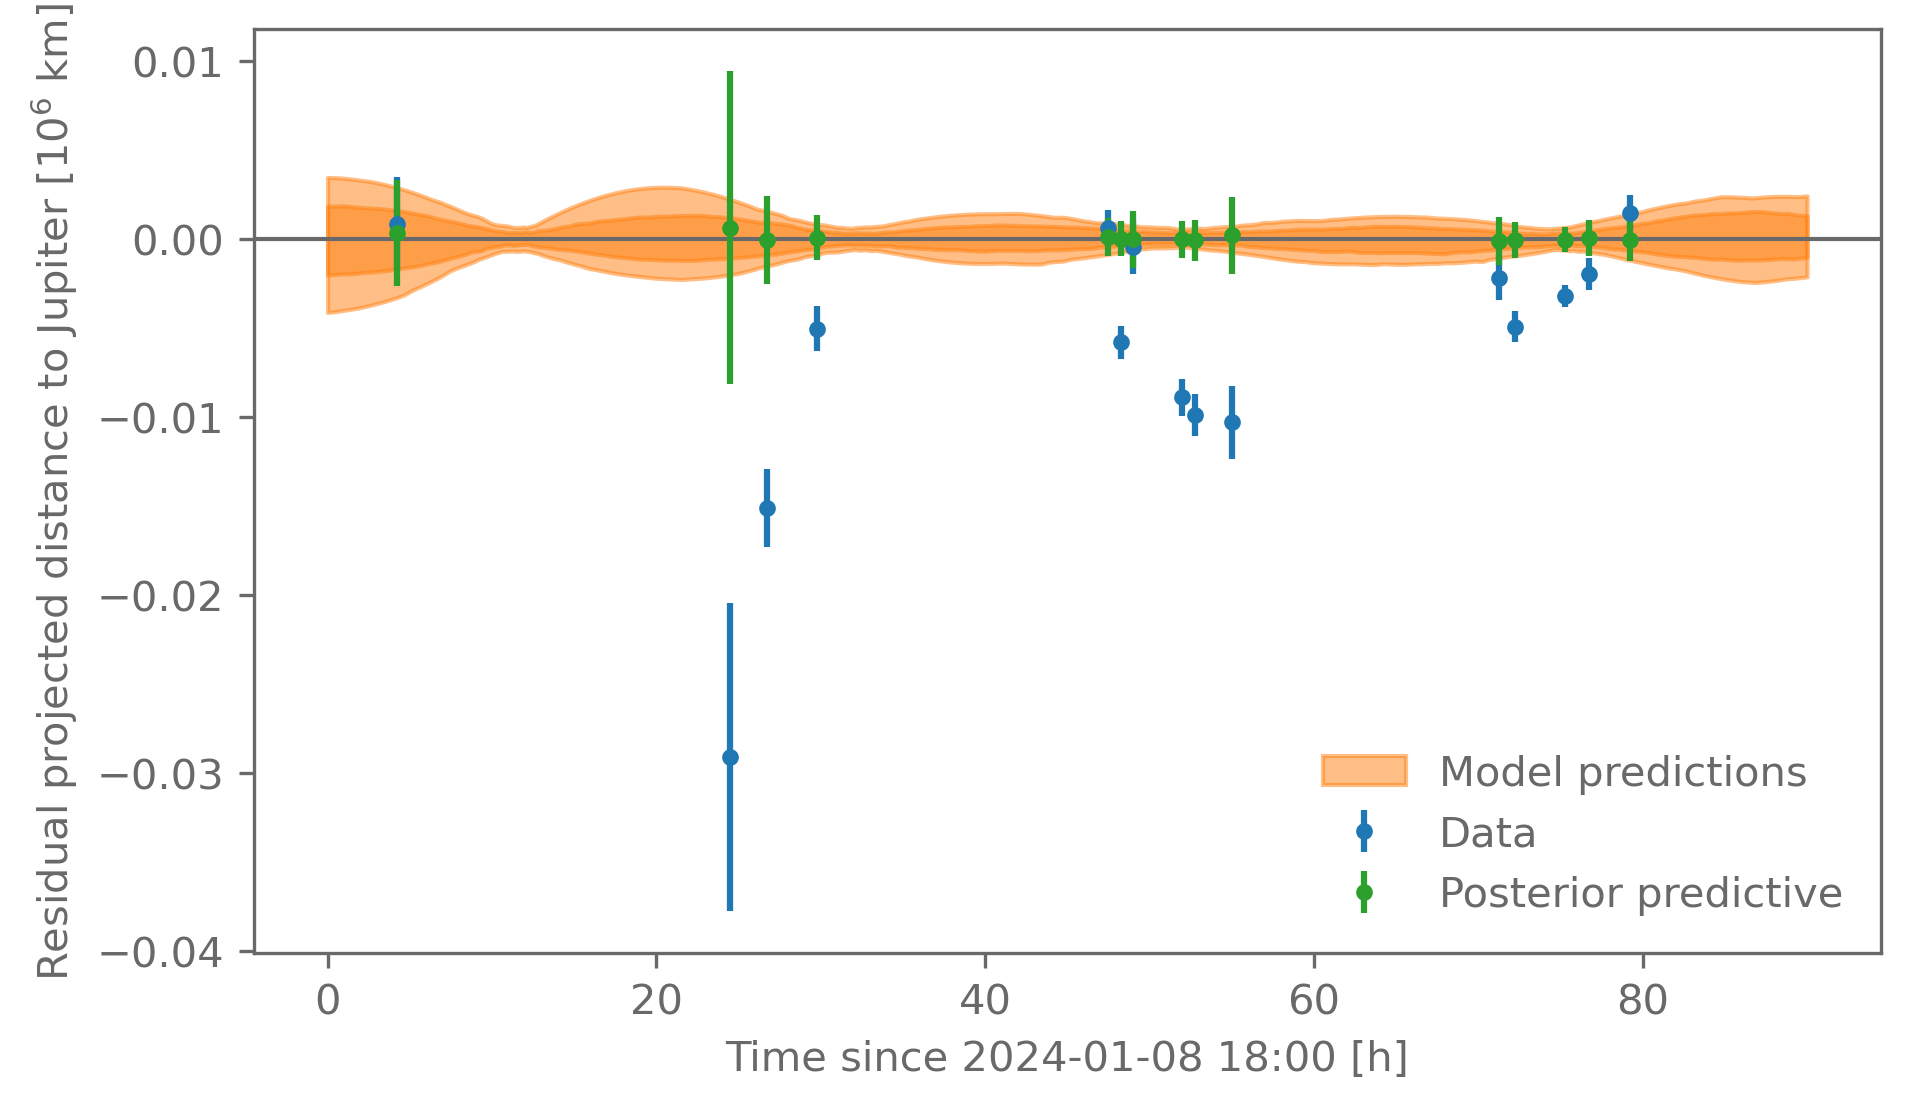

In [157]:
best_fit_model = model(MAP_result.x, t)
best_fit_model_fine = model(MAP_result.x, t_fine)

model_quantiles = np.quantile(
    model_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
)

fig, ax = plot_data(t, distance, distance_err, subtract_y=best_fit_model)

ax.fill_between(t_fine, model_quantiles[1] - best_fit_model_fine, model_quantiles[-2] - best_fit_model_fine,
                alpha=0.5, color="C1", label="Model predictions")
ax.fill_between(t_fine, model_quantiles[0] - best_fit_model_fine, model_quantiles[-1] - best_fit_model_fine,
                alpha=0.5, color="C1")

ax.errorbar(t, posterior_predictive.mean(axis=0) - best_fit_model, posterior_predictive.std(axis=0),
            linestyle="none", marker=".", color="C2", label="Posterior predictive")
_ = ax.legend()

That does not look good! 

What could be the issue?

Compare to the "true" values of the parameters: 
- $a = 0.4217 \cdot 10^6$ km
- $T = 42.456$ h
- $M = 1.8982 \cdot 10^{27}$ kg

Note that in a real experiment you might not have access to such values. 

There can also be good reasons to be blind to such other results.

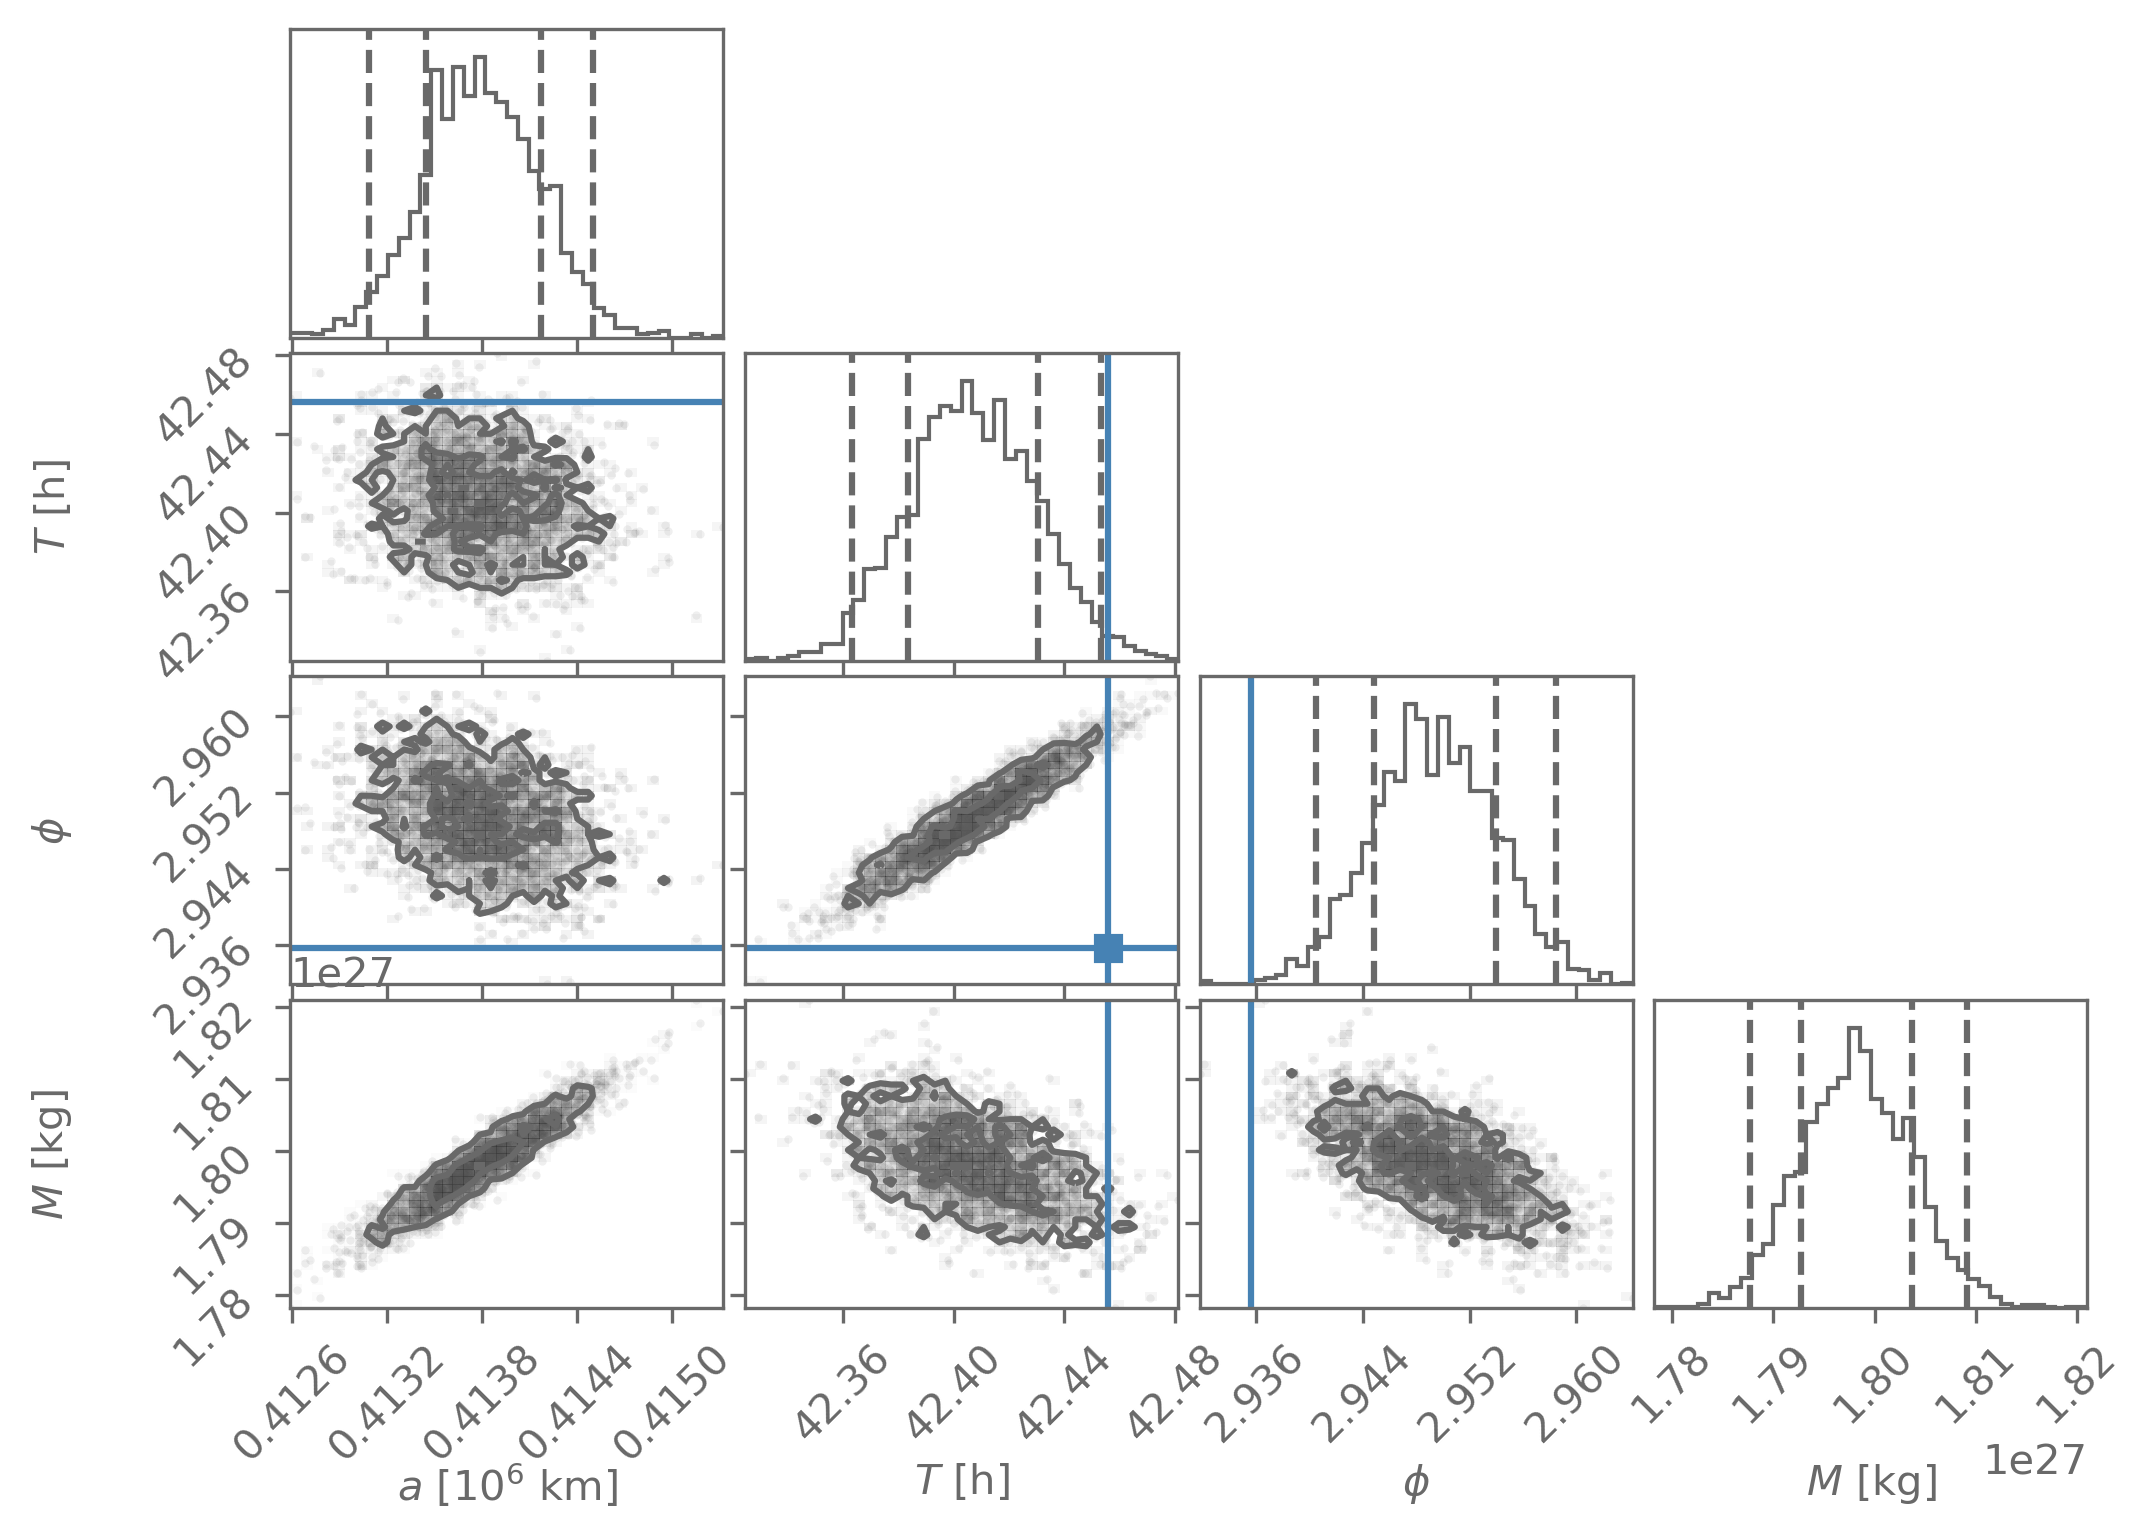

In [174]:
theta_true = dict(
    Io=[0.421700, 1.769*24, 2.935632897970926],
    Ganymede=[1.070400, 7.155*24, 1.5793369771861996],
    Europa=[0.671100, 3.551*24, 3.0779939041348796],
    Callisto=[1.882700, 16.689*24, 1.9374307501130097],
)
mass_Jupiter_true = 1.8982e27


fig = plt.figure(figsize=(7.0, 7.0))
fig = corner.corner(
    chain_with_mass,
    bins=40,
    labels=["$a$ [$10^6$ km]", "$T$ [h]", r"$\phi$", "$M$ [kg]"],
    levels=1-np.exp(-0.5*np.array([1, 2])**2), # Credible contours corresponding to 1 and 2 sigma in 2D
    quantiles=[0.025, 0.16, 0.84, 0.975],
    truths=theta_true[moon] + [mass_Jupiter_true],
    title_quantiles=[0.16, 0.5, 0.84],
    labelpad=0.2,
    fig=fig
)
fig.subplots_adjust(bottom=0.35)

### Exercise

There is another distance estimate provided. The difference between the distance estimates comes from different approaches to converting the measured distance between Jupiter and its moons from the number of pixels to a physical distance in km.

1. How does the analysis look when using this other distance estimate (what I call `distance_alt`)? What about the other moons?



Because there are two distance estimates that do not agree, both of which are based on reasonable approaches, this suggests that there might be a _systematic_ error in the measurements. Systematic errors are usually not random (which means they do not get smaller as you obtain more data). But we could pretend the offset between the two measurements is an estimate of an unaccounted statistical uncertainty. 

2. How does the analysis look when we assume `sigma_d**2 = distance_err**2 + (distance - distance_alt)**2`?



3. Instead of assuming that the uncertainty is underestimated by this offset, we can also model it. Does the model work better if the variance is a free parameter?


### Project idea

Dig deeper into this data set. For example
- Do the modelling assumptions (no eccentricity, no inclination) affect the outcome? You might want to work with simulated data where you know what kind of systematic effects are present.
- Are there other systematics that you can include in the model that better describe the data?
- Do the real (or simulated) data prefer one model over another?
- How to get a combined estimate of the mass of Jupiter from the different moons?